In [1]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,log_loss

from sklearn.calibration import CalibratedClassifierCV

from data_filters import scout_service as sct
from maths.pitch import calculate_shots_coordinates
from maths.trig import calculate_angles
from plots import plot_confusion_matrix,plot_sensitivity_vs_specificity

#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [3]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

### Perguntas

* Porque o Events_ALL.gz tem a coluna index?
* Porque tem tantos valores duplicados da mesma jogada?
* Porque usou o head(100) nos dfs df_HS_predictor e df_HS_response?

In [4]:
# In[Running]
raw = pd.read_csv('database/2023/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
#raw.info()

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4917760 entries, 0 to 4943676
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Codigo                 int32  
 1   Lance                  object 
 2   Nome                   object 
 3   Ocorrencia             object 
 4   PosicaoLance           int32  
 5   TempoPartida           int32  
 6   TimestampStr           object 
 7   atleta_id              int32  
 8   apelido                object 
 9   sigla                  object 
 10  Jogador_Posicao        int32  
 11  Partida_CodigoExterno  float64
 12  tempo                  object 
 13  tempo_2                object 
 14  clube_id               int32  
 15  Codigo_SCT             float64
 16  Partida_CodigoInterno  float64
 17  Rodada                 int32  
 18  Torneio                object 
 19  Edicao                 float64
 20  oponente_id            int32  
 21  home_dummy             float64
 22  CampoPosicaoX     

In [6]:
raw

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,Torneio,Edicao,oponente_id,home_dummy,CampoPosicaoX,CampoPosicaoY,ContraAtaque,Metros,TravePosicaoX,TravePosicaoY
0,74,Passe,Completo,PT26S,13,1,2023-04-15T16:02:10,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,74,Passe,Completo,PT35S,19,1,2023-04-15T16:02:18,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74,Passe,Completo,PT7M36S,26,1,2023-04-15T16:09:21,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74,Passe,Completo,PT8M11S,19,1,2023-04-15T16:09:55,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,Não Encontrado,Perda de Posse de Bola,PT12M34S,25,1,2023-04-15T16:14:20,112370,Emerson Negueba,ATA,...,Brasileiro,2023.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943672,25,Passe,Incompleto,PT51M5S,27,2,2023-11-12T20:28:42,117403,Renato Marques,ATA,...,Brasileiro,2023.0,267,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4943673,33,Arbitragem,Falta Cometida,PT51M8S,20,2,2023-11-12T20:28:45,89226,Iago Maidana,ZAD,...,Brasileiro,2023.0,267,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4943674,34,Arbitragem,Falta Recebida,PT51M9S,17,2,2023-11-12T20:28:45,99198,Vegetti,ATA,...,Brasileiro,2023.0,327,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4943675,74,Passe,Completo,PT51M44S,16,2,2023-11-12T20:29:20,69355,Medel,VOL,...,Brasileiro,2023.0,327,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

# o dataset contém muitos lances duplicados ,por isso precisamos dropar todos os que forem duplicados, mantendo somente a primeira aparição.
raw = raw.drop_duplicates(keep='first').reset_index(drop=True)
#print(raw.info())

## Coordenadas

- Mapear coordenadas de (x,y) no campo e no gol de px para metros
- Calcular o ângulo (degrees e radians) da coordenada (x,y) em relação ao gol


## Nomemclatura

- goal_x_px, goal_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- field_x_px, field_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- goal_x_metros, goal_y_metros -> coordenadas (x,y) em metros, para para o local onde foi feita a finalização
- field_x_metros, field_y_metros -> coordenadas (x,y) em metros, para o local onde foi feita a finalização

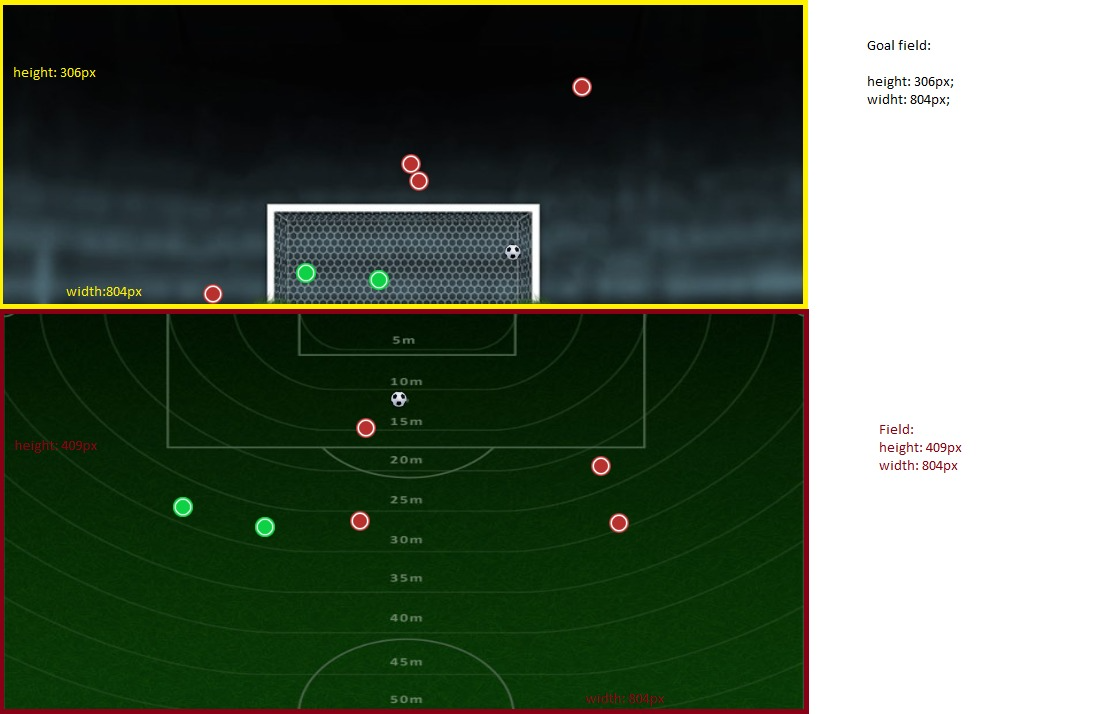

In [8]:
%matplotlib inline
from IPython.display import Image
Image('img/fields.png')

In [9]:
# filtragem por finalizações
df_finalizacoes = calculate_shots_coordinates(raw,'xG')
df_finalizacoes.to_csv('Finalizacoes.csv')
print(df_finalizacoes, df_finalizacoes.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22696 entries, 9 to 1003200
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Codigo                     22696 non-null  int64  
 1   Lance                      22696 non-null  object 
 2   Nome                       22696 non-null  object 
 3   Ocorrencia                 22696 non-null  object 
 4   PosicaoLance               22696 non-null  int64  
 5   TempoPartida               22696 non-null  int64  
 6   TimestampStr               22696 non-null  object 
 7   atleta_id                  22696 non-null  int64  
 8   apelido                    22696 non-null  object 
 9   sigla                      22696 non-null  object 
 10  posicao_id                 22696 non-null  int64  
 11  match_id                   22696 non-null  float64
 12  tempo                      22696 non-null  object 
 13  tempo_2                    22696 non-null  o

In [10]:
print ("Rows     : " ,df_finalizacoes.shape[0])
print ("Columns  : " ,df_finalizacoes.shape[1])
print ("\nFeatures : \n" ,df_finalizacoes.columns.tolist())
print ("\nUnique values :  \n",df_finalizacoes.nunique())
print ("\nMissing values :  ", df_finalizacoes.isnull().sum().values.sum())

Rows     :  22696
Columns  :  43

Features : 
 ['Codigo', 'Lance', 'Nome', 'Ocorrencia', 'PosicaoLance', 'TempoPartida', 'TimestampStr', 'atleta_id', 'apelido', 'sigla', 'posicao_id', 'match_id', 'tempo', 'tempo_2', 'clube_id', 'Codigo_SCT', 'match_id_sct', 'rodada_id', 'Torneio', 'Edicao', 'adversario_id', 'home_dummy', 'CampoPosicaoX', 'CampoPosicaoY', 'ContraAtaque', 'Metros', 'TravePosicaoX', 'TravePosicaoY', 'Goal', 'header', 'goal_x_px', 'goal_y_px', 'field_x_px', 'field_y_px', 'goal_x_metros', 'goal_y_metros', 'field_x_metros', 'field_y_metros', 'Center_dist', 'xG_angle_radians', 'xG_angle_degrees', 'xG_vertical_angle_radians', 'xG_vertical_angle_degrees']

Unique values :  
 Codigo                          25
Lance                            4
Nome                            21
Ocorrencia                    3126
PosicaoLance                    28
TempoPartida                     5
TimestampStr                 11501
atleta_id                     1012
apelido                     

In [11]:
# Convert 'TimestampStr' column to datetime
df_finalizacoes['Timestamp'] = pd.to_datetime(df_finalizacoes['TimestampStr'])
df_finalizacoes['year'] = df_finalizacoes['Timestamp'].dt.year
df_finalizacoes['month'] = df_finalizacoes['Timestamp'].dt.month
df_finalizacoes['day'] = df_finalizacoes['Timestamp'].dt.day

In [12]:
df_finalizacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22696 entries, 9 to 1003200
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Codigo                     22696 non-null  int64         
 1   Lance                      22696 non-null  object        
 2   Nome                       22696 non-null  object        
 3   Ocorrencia                 22696 non-null  object        
 4   PosicaoLance               22696 non-null  int64         
 5   TempoPartida               22696 non-null  int64         
 6   TimestampStr               22696 non-null  object        
 7   atleta_id                  22696 non-null  int64         
 8   apelido                    22696 non-null  object        
 9   sigla                      22696 non-null  object        
 10  posicao_id                 22696 non-null  int64         
 11  match_id                   22696 non-null  float64       
 12  te

### Fazer um recorte do dataframe após o início do provimento dos novos dados do Scout Service

Dados com 0.0 e -1 são faltantes

In [13]:
columns_to_check = ['goal_x_px', 'goal_y_px', 'field_x_px', 'field_y_px']
# Filter rows where all specified columns are not zero
df_finalizacoes = df_finalizacoes[~(df_finalizacoes[columns_to_check] == 0.0).all(axis=1)]

columns_to_check = ['Metros', 'Center_dist']
# Filter rows where all specified columns are not zero
df_finalizacoes = df_finalizacoes[~(df_finalizacoes[columns_to_check] == -1).all(axis=1)]

print(df_finalizacoes)


         Codigo        Lance                    Nome Ocorrencia  PosicaoLance  \
651443        1  Finalização  Fora da Área Bloqueado   PT48M29S            27   
658175       20  Finalização        Dentro Área Fora    PT2M11S            33   
658176       24  Finalização  Fora da Área Para Fora    PT3M16S            28   
658177       24  Finalização  Fora da Área Para Fora   PT19M21S            26   
658178       13  Finalização  Fora da Área Defendido   PT20M58S            27   
...         ...          ...                     ...        ...           ...   
1003027      10  Finalização   Dentro Área Defendido   PT32M21S            34   
1003136      21  Finalização   Dentro Área Bloqueado   PT42M43S            27   
1003143      24  Finalização  Fora da Área Para Fora    PT43M3S            28   
1003150      10  Finalização   Dentro Área Defendido   PT43M50S            33   
1003200      55        Falta                     Gol   PT48M11S            28   

         TempoPartida      

In [14]:
print(df_finalizacoes[['Center_dist','Metros']])

         Center_dist  Metros
651443          25.0    25.0
658175          10.0    10.0
658176          25.0    25.0
658177          25.0    25.0
658178          25.0    25.0
...              ...     ...
1003027          5.0     5.0
1003136         20.0    20.0
1003143         25.0    25.0
1003150         10.0    10.0
1003200         25.0    25.0

[956 rows x 2 columns]


In [15]:
print(set(df_finalizacoes['Torneio']))
#df_finalizacoes.loc[(df_finalizacoes['Torneio']=='Brasileiro')&(df_finalizacoes['Edicao']==2022)&(df_finalizacoes['Rodada']==34)]
print(set(df_finalizacoes[df_finalizacoes['Torneio']=='Brasileiro']['Edicao']))


{'Brasileiro', 'Libertadores'}
{2023.0}


## Visualização Preliminar das Finalizações

In [16]:
#plot_distribution(df_finalizacoes)

In [17]:
#plot_violin_plot(df_finalizacoes)

In [18]:
# removendo linhas com valores ausentes 
df_finalizacoes = df_finalizacoes.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])

#convertendo as colunas 'header' e 'Goal' para valores numéricos
df_finalizacoes['header'] = pd.to_numeric(df_finalizacoes['header'])
df_finalizacoes['Goal'] = pd.to_numeric(df_finalizacoes['Goal'])

In [19]:
# removendo linhas com valores ausentes 
df_finalizacoes = df_finalizacoes.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])

#convertendo as colunas 'header' e 'Goal' para valores numéricos
df_finalizacoes['header'] = pd.to_numeric(df_finalizacoes['header'])
df_finalizacoes['Goal'] = pd.to_numeric(df_finalizacoes['Goal'])
    
#choose specific goals and misses

#Selecionando índices onde houve um gol (Goal==1) e a distância é menor que 12 unidades.
idx_goal = np.where((df_finalizacoes['Goal']==1) & (df_finalizacoes['Metros'] < 12)) 

# criando um novo DataFrame df_HS_goal contendo as linhas selecionadas de acordo com idx_goal.
df_HS_goal = df_finalizacoes.iloc[idx_goal]

# selecionando índices onde não houve gol (Goal==0) e a distância é maior que 13 unidades.
idx_miss = np.where((df_finalizacoes['Goal']==0) & (df_finalizacoes['Metros']> 13)) 

#riando um novo DataFrame df_HS_miss contendo as linhas selecionadas de acordo com idx_miss
df_HS_miss = df_finalizacoes.iloc[idx_miss]


#criando arrays numpy contendo os valores de distância e gol/marcador para os casos de gol e não gol. Parece que você está preparando esses dados para usar em algum tipo de análise ou plotagem posterior.
#plot the heaviside function on top of the responses for the seperable data above
#df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
#df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

In [20]:
#df_HS_goal

In [21]:
#plot_heavside(df_HS_goal,df_HS_miss)

In [22]:
#plot_shots()

In [23]:

#Encontrar os índices das linhas em que ocorreram gols (Goal==1) e a distância é menor que 25 unidades
idx = np.where((df_finalizacoes['Goal']==1) & (df_finalizacoes['Metros'] < 25)) 

#criando um novo DataFrame chamado df_log_goal que contém as linhas selecionadas com base nos índices obtidos anteriormente
df_log_goal = df_finalizacoes.iloc[idx]

#encontrar os índices das linhas em que não ocorreram gols (Goal==0) e a distância é maior que 5 unidades.
idx = np.where((df_finalizacoes['Goal']==0) & (df_finalizacoes['Metros']> 5)) 

#criando um novo DataFrame chamado df_log_miss que contém as linhas selecionadas com base nos novos índices obtidos.
df_log_miss = df_finalizacoes.iloc[idx]

In [24]:
#plot_goal_miss(df_finalizacoes, df_log_goal, df_log_miss)

## O modelo xG

Nosso objetivo é criar um modelo para descrever com precisão nossos dados existentes da melhor forma possível e, eventualmente, prever eventos futuros. Antes de aplicar a regressão logística a todo o nosso conjunto de dados, devemos dividir nossos dados em conjuntos de treinamento e teste. O conjunto de treinamento serve aos dados sobre os quais construímos nosso modelo, e o conjunto de teste são os dados que usamos para avaliar o desempenho de nosso modelo. Ajustar os dados de treinamento à função logística produzirá coeficientes para nossos preditores (farei isso usando a biblioteca Scikit-learn em Python). Se começarmos ajustando apenas a variável de distância, devemos chegar aos parâmetros ideais para descrever os dados de treinamento:

## EDA - Exploratory Data Analysis

In [25]:
df_finalizacoes_EDA = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees', 'header', 'ContraAtaque']]
df_finalizacoes_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 651443 to 1003200
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Goal                       956 non-null    int64  
 1   Metros                     956 non-null    float64
 2   xG_angle_degrees           956 non-null    float64
 3   xG_vertical_angle_degrees  956 non-null    float64
 4   header                     956 non-null    int64  
 5   ContraAtaque               956 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 52.3 KB


In [26]:
print ("Rows     : " ,df_finalizacoes_EDA.shape[0])
print ("Columns  : " ,df_finalizacoes_EDA.shape[1])
print ("\nFeatures : \n" ,df_finalizacoes_EDA.columns.tolist())
print ("\nUnique values :  \n",df_finalizacoes_EDA.nunique())
print ("\nMissing values :  ", df_finalizacoes_EDA.isnull().sum().values.sum())

Rows     :  956
Columns  :  6

Features : 
 ['Goal', 'Metros', 'xG_angle_degrees', 'xG_vertical_angle_degrees', 'header', 'ContraAtaque']

Unique values :  
 Goal                           2
Metros                         9
xG_angle_degrees             945
xG_vertical_angle_degrees    744
header                         2
ContraAtaque                   2
dtype: int64

Missing values :   0


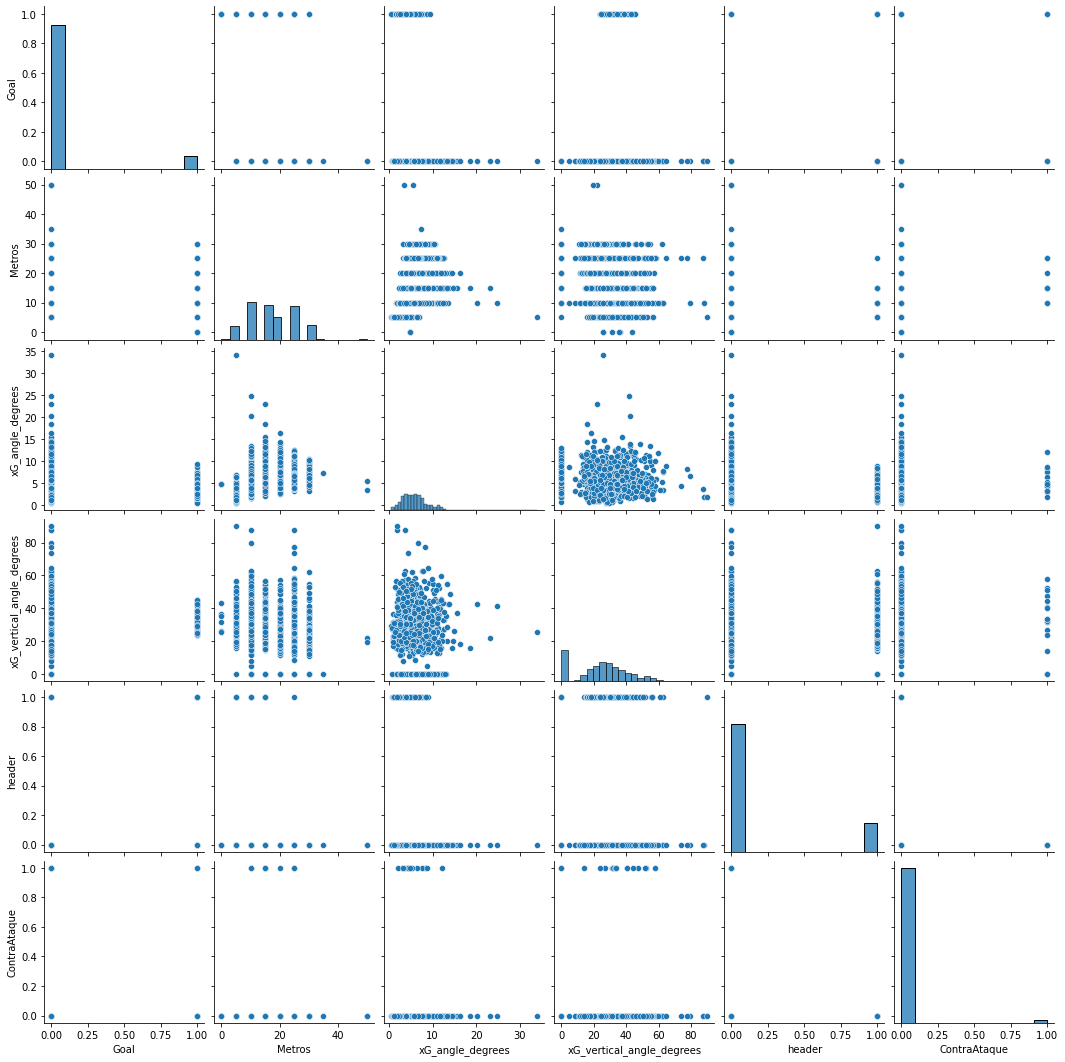

In [27]:
sns.pairplot(df_finalizacoes_EDA)

<AxesSubplot:>

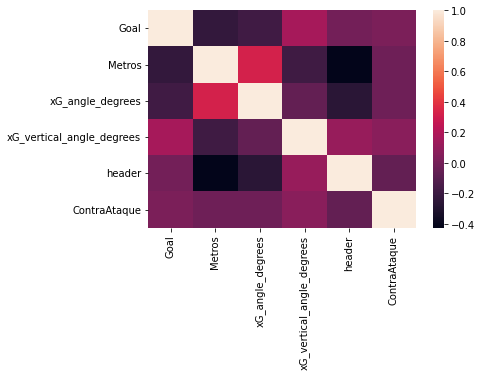

In [28]:
sns.heatmap(df_finalizacoes_EDA.corr())

### Estudo 1 - Distância do Chute

In [29]:
#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor

#Divisão dos dados:
train_dis = df_finalizacoes[['Goal','Metros']].copy()

#O conjunto de treinamento inclui a variável independente "Distance" e a variável dependente "Goal".
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)

#Criação e treinamento do modelo de regressão logística:
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)

#Obtendo os coeficientes do modelo:
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)

#Apresentação dos coeficientes:
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)


#compare this model to the sample data from before

#Comparação com os dados de exemplo:
df_HS_predictor = np.append(df_log_goal['Metros'].head(100), df_log_miss['Metros'].head(100))
df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

[[-0.12165816]] [-0.66445698]


1. Coeficientes do Modelo:
* Coeficiente da variável "Distance": -0.12165816
* Intercepto: -0.66445698

Os coeficientes da regressão logística representam o impacto relativo de cada variável independente (preditora) na probabilidade de ocorrer o evento de interesse (no seu caso, marcar um gol, representado pela variável "Goal").

* Coeficiente da variável "Distance" (-0.12165816): Esse valor negativo indica que, mantendo as outras variáveis constantes, um aumento na distância do chute está associado a uma diminuição nas chances de marcar um gol. Ou seja, quanto maior a distância do chute, menor a probabilidade de marcar um gol.

* Intercepto (-0.66445698): O intercepto é o valor da probabilidade logit quando todas as outras variáveis independentes são iguais a zero. Neste caso, não tem uma interpretação direta em termos do domínio do problema, pois é uma probabilidade logit, que é uma transformação da probabilidade de sucesso (marcar um gol) usando a função logística.

### Estudo 2 - Ângulo do Chute

In [30]:
#similar to before but using ang variable
train_ang = df_finalizacoes[['Goal','xG_angle_degrees','xG_vertical_angle_degrees']].copy()
x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
                                                    train_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

lgm_ang = LogisticRegression()
lgm_ang.fit(x_train_ang,y_train_ang)
log_odds_ang = lgm_ang.coef_[0]

print(lgm_ang.coef_, lgm_ang.intercept_)

pd.DataFrame(log_odds_ang, 
             x_train_ang.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.34575506  0.03968535]] [-1.85046492]


,coef
xG_vertical_angle_degrees,0.039685
xG_angle_degrees,-0.345755


### Estudo 3 - Distância e Ângulo do Chute

In [31]:
train_2 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                        train_2['Goal'], test_size=0.20, 
                                                        random_state=10)
        
lgm_2 = LogisticRegression(random_state=0)
lgm_2.fit(x_train_2,y_train_2)

log_odds = lgm_2.coef_[0]

print(lgm_2.coef_, lgm_2.intercept_)

print(pd.DataFrame(log_odds, 
             x_train_2.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))


def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)

h_grid = Logistic(lgm_2.coef_[0][1]*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  +lgm_2.coef_[0][0]*np.sqrt((x1_grid)**2+(x0_grid)**2)+lgm_2.intercept_[0])

[[-0.06911238 -0.22522615  0.03767011]] [-1.38394358]
                               coef
xG_vertical_angle_degrees  0.037670
Metros                    -0.069112
xG_angle_degrees          -0.225226


## Avaliação do Modelo 

Se quisermos avaliar a precisão de nosso modelo, temos que testar quão bem ele pode prever eventos futuros. Mas isso levanta outra preocupação. Como classificamos uma finalização com nosso novo modelo de metas esperadas? Ao contrário da função Heaviside, que fornece classificações rígidas, o modelo de regressão logística retorna a probabilidade de um chute resultar em um gol.

Para fazer uma classificação, temos que definir um limite. Esse limite essencialmente divide a função logística, atribuindo metas para onde o modelo está acima do limite e falha abaixo. Por exemplo:

In [32]:
# plot logistic model with 3 different thresholds
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.3,threshold_x=6.5)
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.1,threshold_x=16)
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.02,threshold_x=28)

In [33]:
train_dis = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees']].copy()

#O conjunto de treinamento inclui a variável independente "Distance" e a variável dependente "Goal".
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)

#Criação e treinamento do modelo de regressão logística:
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)

#Obtendo os coeficientes do modelo:
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)

#Apresentação dos coeficientes:
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)


#compare this model to the sample data from before

#Comparação com os dados de exemplo:
df_HS_predictor = np.append(df_log_goal['Metros'].head(100), df_log_miss['Metros'].head(100))
df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

[[-0.06911238 -0.22522615  0.03767011]] [-1.38394358]


[[169   6]
 [ 15   2]]
[[132  43]
 [  6  11]]
[[ 54 121]
 [  0  17]]


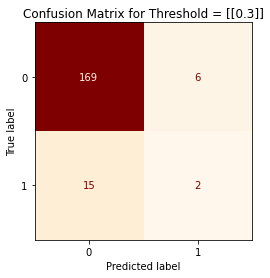

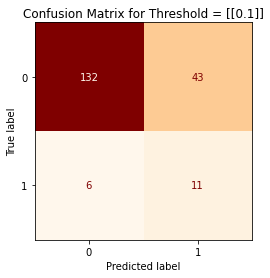

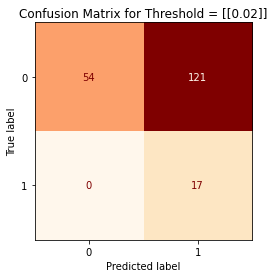

In [34]:
# test confusion matrix with 3 thresholds
cm_dis_03 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.3])
cm_dis_01 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.1])
cm_dis_002 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.02])

In [35]:
sensitivity_3, specificity_3 = plot_sensitivity_vs_specificity(cm_dis_03,0.3)
sensitivity_10, specificity_10 = plot_sensitivity_vs_specificity(cm_dis_01,0.1)
sensitivity_02, specificity_02 = plot_sensitivity_vs_specificity(cm_dis_002,0.02)

sensitivity when threshold: 0.3 = 0.11764705882352941
specificity when threshold:0.3 = 0.9657142857142857
6
sensitivity when threshold: 0.1 = 0.6470588235294118
specificity when threshold:0.1 = 0.7542857142857143
43
sensitivity when threshold: 0.02 = 1.0
specificity when threshold:0.02 = 0.30857142857142855
121



Agora prevemos gols e erros em uma taxa mais equilibrada. Vimos que três limites diferentes produzem previsões muito diferentes de nosso modelo. Onde eles variam é em sua especificidade e sensibilidade; ou seja, sua capacidade de prever corretamente os gols e erros. É uma troca. Então, que limite escolhemos? Bem, nenhum deles e todos eles.

Vamos dar um passo para trás. Se estivéssemos usando um modelo de regressão logística para identificar se um paciente tem câncer, então adotaríamos um limite alto, para renunciar a uma alta taxa de especificidade em favor de uma alta sensibilidade. Preferimos dar resultados falsos positivos em vez de falsos negativos. Não queremos que alguém saia pensando que foi aprovado em um exame de câncer, quando na verdade ele tem câncer. Quando tentamos modelar a probabilidade do objetivo, não temos essa preferência. Na verdade, tentar prever metas diretamente não é tão útil para começar. Como veremos na próxima parte, o poder do modelo de gol esperado não está em fazer uma previsão para um único tiro. Então, qual foi o propósito de investigar limites e matrizes de confusão? Podemos usá-los para comparar diferentes modelos usando algo conhecido como gráfico Receiver Operator Characteristic (ROC).

Text(0.5, 1.0, 'ROC Graph')

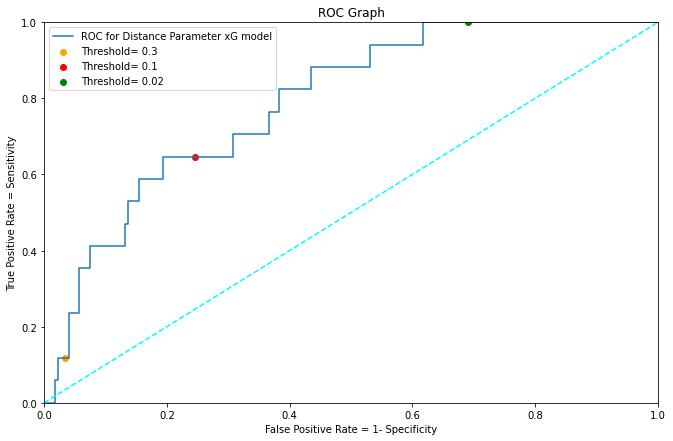

In [36]:
fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model')

plt.scatter(1-specificity_3,sensitivity_3,c='orange',label='Threshold= 0.3')
plt.scatter(1-specificity_10,sensitivity_10,c='red',label='Threshold= 0.1')
plt.scatter(1-specificity_02,sensitivity_02,c='green',label='Threshold= 0.02')
y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')

Usando um pequeno *step size*, a curva ROC representa a capacidade do modelo de prever as metas corretamente versus sua capacidade de prever incorretamente as perdas para diferentes valores de limite. Conforme você move para cima no eixo y, o modelo prevê melhor as metas, e conforme nos movemos para a esquerda ao longo do eixo x, o modelo prevê melhor os erros. Basicamente, ele mapeia o equilíbrio entre a previsão de metas e a previsão de erros. A linha tracejada representa um modelo que não tem poder preditivo e é essencialmente inútil porque para cada classificação correta, ela também prevê uma classificação incorreta. Portanto, quanto mais longe nossa curva ROC está da linha de 45 graus, melhor é o trabalho geral que ela realiza na classificação dos dados de teste. Outra maneira de ver isso é que quanto maior a área sob a curva, melhor será o nosso modelo para descrever os dados de teste. Isso é útil para nós porque podemos usá-lo para comparar modelos diferentes e ver se há alguma vantagem substancial em adicionar mais variáveis ​​ao nosso modelo.

In [37]:
train_3 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','header']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3.drop('Goal',axis=1), 
                                                    train_3['Goal'], test_size=0.20, 
                                                    random_state=10)
lgm_3 = LogisticRegression()
lgm_3.fit(x_train_3,y_train_3)
log_odds = lgm_3.coef_[0]
print(lgm_3.coef_, lgm_3.intercept_)

train_4 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','header','ContraAtaque']].copy()
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
                                                    train_4['Goal'], test_size=0.20, 
                                                    random_state=10)
lgm_4 = LogisticRegression()
lgm_4.fit(x_train_4,y_train_4)
log_odds = lgm_4.coef_[0]
print(lgm_4.coef_, lgm_4.intercept_)

[[-0.08855096 -0.23179629  0.03910843 -1.17341207]] [-0.88848324]
[[-0.08789357 -0.23399356  0.03967411 -1.184734   -0.39555806]] [-0.89388609]


Text(0.5, 1.0, 'ROC Graph')

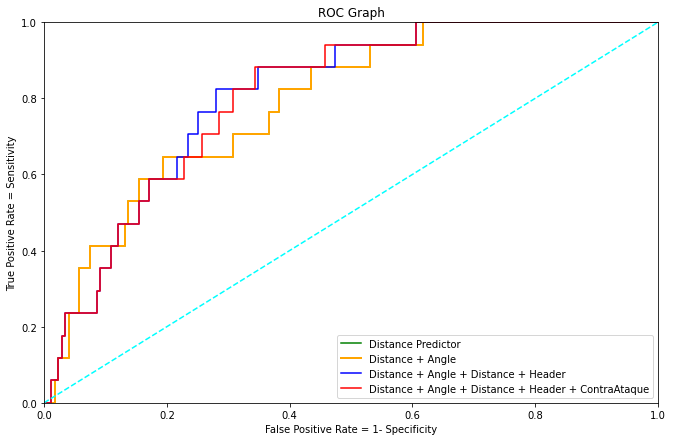

In [38]:
fig, axes = plt.subplots(figsize=(11,7))

y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='Distance Predictor',c='green')

y_score_2 = lgm_2.decision_function(x_test_2)
fpr2, tpr2, _  = roc_curve(y_test_2,y_score_2, pos_label=lgm_2.classes_[1])
plt.plot(fpr2,tpr2,label='Distance + Angle',c='orange',linewidth=2)

y_score_3 = lgm_3.decision_function(x_test_3)
fpr_3, tpr_3, _  = roc_curve(y_test_3,y_score_3, pos_label=lgm_3.classes_[1])
plt.plot(fpr_3,tpr_3,label='Distance + Angle + Distance + Header',c='blue')

y_score_4 = lgm_4.decision_function(x_test_4)
fpr_4, tpr_4, _  = roc_curve(y_test_4,y_score_4, pos_label=lgm_4.classes_[1])
plt.plot(fpr_4,tpr_4,label='Distance + Angle + Distance + Header + ContraAtaque',c='red')
plt.legend()


y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')

Agora temos algo concreto ao avaliar nosso modelo. Se olharmos de perto, um modelo com distância e ângulo como variáveis ​​de entrada produz a mesma área sob a curva (AUC) que o mesmo modelo, mas com um parâmetro de "distância ao centro" adicionado. Portanto, ao contrário de algumas das suposições que fizemos anteriormente, o preditor de “distância ao centro” não acrescenta muito ao desempenho de nosso modelo e devemos excluí-lo. Embora o parâmetro “distância até o centro” tenha mostrado uma ligeira mudança no modelo em áreas próximas à linha de gol, essa mudança significou muito pouco, já que poucos chutes são feitos a partir dessas posições. O AUC, portanto, nos diz que adicionar o centro à variável de distância é bastante inútil. Observe que poderíamos ter usado os valores p com a mesma facilidade para saber se o parâmetro centro para distância é útil para o nosso modelo.

Outra vantagem da curva ROC é que se optássemos por usar outras técnicas de classificação, como SVM, florestas aleatórias, redes neurais, etc., poderíamos comparar e contrastar o desempenho desses modelos com o que criamos aqui. Acho que isso é um exagero para o problema em questão, mas é um caminho para uma exploração mais aprofundada. Embora esses modelos alternativos produzam resultados semelhantes, a regressão logística nos fornece um método bastante simples e digerível para descrever os resultados das tomadas, ao passo que esses outros métodos requerem um entendimento mais profundo e sofisticado das técnicas de aprendizado de máquina.

## Escolha Preliminar: Regressão Logística
#### Vetores:
- Distância
- Ângulo
- Cabeçada

In [39]:
train_5 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy()
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(train_5.drop('Goal',axis=1), 
                                                    train_5['Goal'], test_size=0.20, 
                                                    random_state=10)

lgm_5 = LogisticRegression(fit_intercept=False,solver='lbfgs')
lgm_5.fit(x_train_5,y_train_5)

y_pred = lgm_5.predict_proba(x_test_5)[:,1]
y_hat = lgm_5.predict_proba(train_5.drop('Goal',axis=1))[:,1]
y_hat.shape

(956,)

Mais uma vez, testamos ROC neste modelo

In [63]:
# test for best parameter model
pred_proba_df = pd.DataFrame(lgm_5.predict_proba(x_test_5))
# thresholds values
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test_5.to_numpy().reshape(y_test_5.to_numpy().size,1),
                                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test_5.to_numpy().reshape(y_test_5.to_numpy().size,1),
                           Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.6822916666666666
[[117  58]
 [  3  14]]

******** For i = 0.1 ******
Our testing accuracy is 0.8020833333333334
[[144  31]
 [  7  10]]

******** For i = 0.15 ******
Our testing accuracy is 0.84375
[[154  21]
 [  9   8]]

******** For i = 0.2 ******
Our testing accuracy is 0.8645833333333334
[[159  16]
 [ 10   7]]

******** For i = 0.25 ******
Our testing accuracy is 0.8697916666666666
[[163  12]
 [ 13   4]]

******** For i = 0.3 ******
Our testing accuracy is 0.8854166666666666
[[166   9]
 [ 13   4]]

******** For i = 0.35 ******
Our testing accuracy is 0.8958333333333334
[[168   7]
 [ 13   4]]

******** For i = 0.4 ******
Our testing accuracy is 0.9010416666666666
[[170   5]
 [ 14   3]]

******** For i = 0.45 ******
Our testing accuracy is 0.8958333333333334
[[171   4]
 [ 16   1]]

******** For i = 0.5 ******
Our testing accuracy is 0.9010416666666666
[[172   3]
 [ 16   1]]

******** For i = 0.55 ******
Our testing accuracy is 0.

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [42]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # container pra todas as probabilidades do dataset
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        precision_scores = []  # List to store precision scores

        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para teste e o resto 
        # para treino (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit apenas no conjunto de treino:
            scaler.fit(X[treino])
            # Vamos escalar tanto os dados de treino quanto de teste.
            X_treino_escalado = scaler.transform(X[treino])
            X_teste_escalado = scaler.transform(X[teste])
            # Fit do modelo nos dados de treino:
            modelo.fit(X_treino_escalado, y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X_teste_escalado)                    
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            precision_scores.append(precision_score(y[teste], y_pred))  # Calculate precision
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X_teste_escalado)
            # logistic regression predicts probability for both classes; pick only class '1'
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score[:, 1]))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Precisao"].append(np.mean(precision_scores))  # Add precision average to results
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [64]:
X = df_finalizacoes[['Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy().values
y = df_finalizacoes[['Goal']].values.reshape(-1)

print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Precisao" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }
# avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)


# definindo as diferentes configurações para o método NB
modelos_gaussian = {
    "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
    "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
    "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
    "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
    "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
}

avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# definindo as diferentes configurações para o método KNN

modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11),
}

avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(956, 5)
(956,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametrização

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.9121162280701756,
  0.5868530701754386,
  0.7280043859649122,
  0.9047916666666668,
  0.9173574561403509,
  0.9058333333333334,
  0.896436403508772,
  0.9027302631578948,
  0.9027302631578948,
  0.9027302631578948,
  0.9027302631578948,
  0.9027

In [66]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Precisao,Roc_auc
0,Logistic Regression,Logistic Regression,0.912116,0.497708,0.000000,0.805200
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.586853,0.695050,0.147921,0.800222
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.728004,0.726646,0.198293,0.808533
3,XGBoost,XGBoost Default,0.904792,0.601626,0.426190,0.858635
4,XGBoost,"XGBoost with max_depth=3, learning_rate=0.1",0.917357,0.557354,0.358333,0.879849
5,XGBoost,"XGBoost with subsample=0.7, colsample_bytree=0.8",0.905833,0.585162,0.326190,0.848820
6,XGBoost,XGBoost with scale_pos_weight for imbalanced,0.896436,0.631139,0.386667,0.857494
7,GaussianNB,Var smoothing 1e-9,0.902730,0.555048,0.380952,0.846091
8,GaussianNB,Var smoothing 1e-8,0.902730,0.555048,0.380952,0.846091
9,GaussianNB,Var smoothing 1e-7,0.902730,0.555048,0.380952,0.846091


In [67]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
GaussianNB,0.846091
KNN,0.853257
Logistic Regression,0.808533
XGBoost,0.879849


In [68]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='GaussianNB', Roc_auc=0.8460913009404389)
Melhor parametrização do GaussianNB = Var smoothing 1e-9
Pandas(Index='KNN', Roc_auc=0.8532572492163011)
Melhor parametrização do KNN = N=11
Pandas(Index='Logistic Regression', Roc_auc=0.8085325235109717)
Melhor parametrização do Logistic Regression = Logistic Regression, Weights Balanced
Pandas(Index='XGBoost', Roc_auc=0.8798491379310344)
Melhor parametrização do XGBoost = XGBoost with max_depth=3, learning_rate=0.1


In [47]:
df_finalizacoes

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,field_y_metros,Center_dist,xG_angle_radians,xG_angle_degrees,xG_vertical_angle_radians,xG_vertical_angle_degrees,Timestamp,year,month,day
651443,1,Finalização,Fora da Área Bloqueado,PT48M29S,27,2,2023-10-30T15:23:10,98517,Jean Lucas,VOL,...,30.555556,25.0,0.117853,6.752476,0.000000,0.000000,2023-10-30 15:23:10,2023,10,30
658175,20,Finalização,Dentro Área Fora,PT2M11S,33,1,2023-11-02T21:05:34,68942,Luciano Castán,ZAE,...,12.091503,10.0,0.135563,7.767186,0.527504,30.223743,2023-11-02 21:05:34,2023,11,2
658176,24,Finalização,Fora da Área Para Fora,PT3M16S,28,1,2023-11-02T20:03:46,96966,Arthur Gomes,ATA,...,32.352941,25.0,0.105510,6.045300,0.313982,17.989819,2023-11-02 20:03:46,2023,11,2
658177,24,Finalização,Fora da Área Para Fora,PT19M21S,26,1,2023-11-02T20:19:54,91706,Marlon,LAE,...,33.006536,25.0,0.187104,10.720241,0.332301,19.039454,2023-11-02 20:19:54,2023,11,2
658178,13,Finalização,Fora da Área Defendido,PT20M58S,27,1,2023-11-02T20:23:47,91689,Matheus Jussa,VOL,...,33.169935,25.0,0.158550,9.084254,0.739975,42.397438,2023-11-02 20:23:47,2023,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003027,10,Finalização,Dentro Área Defendido,PT32M21S,34,2,2023-11-12T20:10:21,99198,Vegetti,ATA,...,4.248366,5.0,0.020330,1.164833,0.545541,31.257202,2023-11-12 20:10:21,2023,11,12
1003136,21,Finalização,Dentro Área Bloqueado,PT42M43S,27,2,2023-11-12T20:21:03,60825,Felipe Azevedo,ATA,...,22.712418,20.0,0.130480,7.475956,0.000000,0.000000,2023-11-12 20:21:03,2023,11,12
1003143,24,Finalização,Fora da Área Para Fora,PT43M3S,28,2,2023-11-12T20:20:47,81091,Jair,VOL,...,33.006536,25.0,0.115336,6.608266,0.242591,13.899434,2023-11-12 20:20:47,2023,11,12
1003150,10,Finalização,Dentro Área Defendido,PT43M50S,33,2,2023-11-12T20:21:59,103388,Emmanuel Martínez,MEC,...,12.254902,10.0,0.100688,5.769006,0.650574,37.275166,2023-11-12 20:21:59,2023,11,12


## Modelo Escolhido - Logistic Regression
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False

## O vetor xG

#### Criamos o modelo xG para o campeonato desejado

Criemos um método que recebe o dataset de finalizações para treino e teste. Este método aceita filtragem por campeonato.

In [48]:
!pip install xgboost

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [50]:
def logistic_regression_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset'
    dataset = df[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal',axis=1), 
                                                        dataset['Goal'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

#     # escalar os dados
#     scaler = StandardScaler()

#     # Fit apenas no conjunto de treino:
#     scaler.fit(X_train)

#     # Vamos escalar tanto os dados de treino quanto de teste.
#     X_treino_escalado = scaler.transform(X_train)
#     X_teste_escalado = scaler.transform(X_test)

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Goal',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xG'] = y_hat
    return df

In [51]:
# def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):
#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     # Inicializar o dataset
#     dataset = df[['Goal','Distance','Angle Radians','header']].copy()

#     # Dividir em treino e teste
#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), 
#                                                         dataset['Goal'], test_size=0.20, 
#                                                         random_state=10)

#     # Inicializar o modelo XGBoost
#     xgb_model = XGBClassifier()

#     # Treinar o modelo
#     xgb_model.fit(X_train, y_train)

#     # Fazer previsões no conjunto de teste
#     y_pred = xgb_model.predict(X_test)

#     # Avaliar a precisão do modelo
#     accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy:", accuracy)

#     # Fazer previsões no conjunto completo
#     y_probs = xgb_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

#     # Adicionar probabilidades xG ao DataFrame original
#     df['xG'] = y_probs

#     return df

def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):

    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    dataset = df[['Goal','Metros','xG_angle_degrees', 'xG_vertical_angle_degrees', 'ContraAtaque','header']].copy()
    dataset['Metros*xG_angle_degrees'] = dataset['Metros'] * dataset['xG_angle_degrees']

    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), dataset['Goal'], test_size=0.20, random_state=10)

    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
    calibrated_clf.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Log Loss:", logloss)
    print("AUC:", auc)

    y_probs = calibrated_clf.predict_proba(dataset.drop('Goal', axis=1))[:, 1]
    df['xG'] = y_probs

    return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [52]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
df_geral = xgboost_xG(df=df_finalizacoes)
#df_geral = logistic_regression_xG(df=df_finalizacoes)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro = df_geral.loc[(df_finalizacoes['Torneio']=='Brasileiro')&(df_finalizacoes['Edicao']==2023)]

Accuracy: 0.9166666666666666
Log Loss: 0.2376289705309773
AUC: 0.6356302521008403


In [53]:
#df_geral.to_csv('/Users/vitor.patalano/Documents/globo/gato_mestre/betting/database/footstats/xG.csv', index=False)

In [54]:
df_brasileiro = df_brasileiro.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [55]:
df_brasileiro.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro['rodada_id'].max()
print(rodada)

34


In [56]:
df_brasileiro['rodada_id'].nunique()

5

In [57]:
df_brasileiro[df_brasileiro['clube_id']==262]['rodada_id'].nunique()

4

### Trazer Dataset Cartola

In [58]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2023/Cartola_2023_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [59]:
times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

times_dict_r = {v:k for k, v in times_dict.items()}
clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Santos':'![Santos](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/santos_60x60.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athlético-PR':'![Athlético-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'América-MG':' ![América-MG](https://s.glbimg.com/es/sde/f/organizacoes/2019/02/28/escudo65_1.png)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Coritiba':'![Coritiba](https://s.glbimg.com/es/sde/f/organizacoes/2017/03/29/coritiba65.png)',
'Goiás':'![Goiás](https://s.glbimg.com/es/sde/f/organizacoes/2019/05/01/Goias_65px.png)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }

### Trazer mando de campo a partir das partidas

In [60]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xG Clubes
Calcular o xG agregado por clubes.

- somar o xG total
- somar o xG por partida
- calcular a média por partida
- comparar total vs média

In [61]:
df_brasileiro

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,Center_dist,xG_angle_radians,xG_angle_degrees,xG_vertical_angle_radians,xG_vertical_angle_degrees,Timestamp,year,month,day,xG
651443,1,Finalização,Fora da Área Bloqueado,PT48M29S,27,2,2023-10-30T15:23:10,98517,Jean Lucas,VOL,...,25.0,0.117853,6.752476,0.000000,0.000000,2023-10-30 15:23:10,2023,10,30,0.001301
658175,20,Finalização,Dentro Área Fora,PT2M11S,33,1,2023-11-02T21:05:34,68942,Luciano Castán,ZAE,...,10.0,0.135563,7.767186,0.527504,30.223743,2023-11-02 21:05:34,2023,11,2,0.001352
658176,24,Finalização,Fora da Área Para Fora,PT3M16S,28,1,2023-11-02T20:03:46,96966,Arthur Gomes,ATA,...,25.0,0.105510,6.045300,0.313982,17.989819,2023-11-02 20:03:46,2023,11,2,0.001306
658177,24,Finalização,Fora da Área Para Fora,PT19M21S,26,1,2023-11-02T20:19:54,91706,Marlon,LAE,...,25.0,0.187104,10.720241,0.332301,19.039454,2023-11-02 20:19:54,2023,11,2,0.001308
658178,13,Finalização,Fora da Área Defendido,PT20M58S,27,1,2023-11-02T20:23:47,91689,Matheus Jussa,VOL,...,25.0,0.158550,9.084254,0.739975,42.397438,2023-11-02 20:23:47,2023,11,2,0.001547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003027,10,Finalização,Dentro Área Defendido,PT32M21S,34,2,2023-11-12T20:10:21,99198,Vegetti,ATA,...,5.0,0.020330,1.164833,0.545541,31.257202,2023-11-12 20:10:21,2023,11,12,0.019066
1003136,21,Finalização,Dentro Área Bloqueado,PT42M43S,27,2,2023-11-12T20:21:03,60825,Felipe Azevedo,ATA,...,20.0,0.130480,7.475956,0.000000,0.000000,2023-11-12 20:21:03,2023,11,12,0.001303
1003143,24,Finalização,Fora da Área Para Fora,PT43M3S,28,2,2023-11-12T20:20:47,81091,Jair,VOL,...,25.0,0.115336,6.608266,0.242591,13.899434,2023-11-12 20:20:47,2023,11,12,0.001301
1003150,10,Finalização,Dentro Área Defendido,PT43M50S,33,2,2023-11-12T20:21:59,103388,Emmanuel Martínez,MEC,...,10.0,0.100688,5.769006,0.650574,37.275166,2023-11-12 20:21:59,2023,11,12,0.001836


In [62]:
# xG total
df_clubes_xg_total = df_brasileiro.groupby(['clube_id'])['xG'].agg([('xG_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xg_match = df_brasileiro.groupby(['clube_id','rodada_id'])['xG'].agg([('xG_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xg_mean = df_clubes_xg_match.groupby('clube_id')['xG_sum'].agg([('xG_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xg_std = df_brasileiro.groupby('clube_id')['xG'].agg([('xG_std',np.std)]).reset_index()
# gols
df_clubes_g_total = df_cartola.groupby('clube_id')['G'].agg([('G_total','sum')]).reset_index()
# merge
df_clubes_xg = df_clubes_xg_total.merge(df_clubes_xg_mean, on='clube_id')
# merge again
df_clubes_xg_vs_g = df_clubes_xg.merge(df_clubes_g_total, on='clube_id')
# and again
df_clubes_xg_vs_g = df_clubes_xg_vs_g.merge(df_clubes_xg_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xg_vs_g['clube'] = df_clubes_xg_vs_g['clube_id'].map(times_dict_r)
df_clubes_xg_vs_g['clube'] = df_clubes_xg_vs_g['clube'].map(team_icons)
# sort por média xG
df_clubes_xg_vs_g = df_clubes_xg_vs_g.sort_values(by='xG_total',ascending=False).reset_index(drop=True)[['clube', 'xG_mean', 'xG_total','G_total']]
df_clubes_xg_vs_g.dropna()

#df_clubes_xg_vs_g.to_csv(f'conteudo/xG_vs_Goals_R{rodada}.csv', index=False)

df_clubes_xg_vs_g

,clube,xG_mean,xG_total,G_total
0,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.994722,7.978888,55.0
1,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.732855,6.931421,49.0
2,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.688448,6.753793,52.0
3,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.001086,6.003258,42.0
4,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.264506,5.058023,51.0
5,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,1.057593,4.230372,37.0
6,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.025599,4.102397,43.0
7,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,1.005887,4.023549,35.0
8,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.105579,3.316736,35.0
9,![Santos](https://s.glbimg.com/es/sde/f/organi...,0.608822,3.044110,33.0


# Expected Points (xP)

Quanto se esperaria que estivesse a tabela do campeonato de acordo com xG

In [66]:
def confrontos_xG(df_brasileiro):
    confrontos_xg = df_brasileiro.groupby(['clube_id', 'adversario_id'])['xG'].agg([('xG_sum','sum')]).reset_index()

    df_confrontos_xg = confrontos_xg.merge(
                                        confrontos_xg.set_index(['adversario_id','clube_id']),
                                        left_on=['clube_id','adversario_id'],
                                        right_index=True,
                                        suffixes=('_clube','_adversario'),
                                        how='left'
                                    )
    df_confrontos_xg['clube'] = df_confrontos_xg['clube_id'].map(times_dict_r)
    df_confrontos_xg['adversario'] = df_confrontos_xg['adversario_id'].map(times_dict_r)
    return df_confrontos_xg

confrontos_xG(df_brasileiro)

,clube_id,adversario_id,xG_sum_clube,xG_sum_adversario,clube,adversario
0,0,0,3.473834,3.473834,NaN,NaN
1,262,263,3.215694,2.050704,Flamengo,Botafogo
2,262,264,0.500392,0.244743,Flamengo,Corinthians
3,262,265,2.110955,1.034400,Flamengo,Bahia
4,262,266,0.634139,1.909071,Flamengo,Fluminense
...,...,...,...,...,...,...
370,1371,290,1.160547,0.149570,Cuiabá,Goiás
371,1371,293,0.248475,2.391037,Cuiabá,Athlético-PR
372,1371,294,0.081315,0.590190,Cuiabá,Coritiba
373,1371,327,0.457003,0.317137,Cuiabá,América-MG


# Justice Table
Vamos refazer a tabela 'justa', isto é, de como deveriam estar os times na realidade posicionados no campeonato em função de suas performances
## Simulação 
Simulação de confrontos efetivamente realizados, com base nos xG dos jogos

In [67]:
def xP(df, table=False):
    # Poisson with MonteCarlo Simulation
    all_team = []
    all_adversary=[]
    all_draws=[]
    all_team_xP = []
    all_adversary_xP = []
    num_simulations = 100000

    for i,row in df.iterrows():
        clube = df.iloc[i]['clube']
        if table:
            print("* Game #", i+1, "*")
            print("* Team:", df.iloc[i]['clube'])
            print("* Adversary:", df.iloc[i]['adversario'])
            print("* Team xG:", df.iloc[i]['xG_sum_clube'])
            print("* Adversary xG:", df.iloc[i]['xG_sum_adversario'])
        input_team = df.iloc[i]['clube_id']
        input_adversary = df.iloc[i]['adversario_id']
        input_team_xg = df.iloc[i]['xG_sum_clube']
        input_adversary_xg = df.iloc[i]['xG_sum_adversario']

        #print the simulation table and run simulations
        # print ("********************")
        # print ("*                  *")
        # print ("* SIMULATION TABLE *")
        # print ("*                  *")
        # print ("********************")
        count_team_wins = 0
        count_team_loss = 0
        count_adversary_wins = 0
        count_adversary_loss = 0
        count_draws = 0

        score_mat = []
        tot_sim_time = 0
        sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_team, input_adversary, "TEAM WIN", "ADVERSARY WIN", "DRAW", "SCORE MARGIN"])
        for i in range(num_simulations):
            #get simulation start time
            start_time = time.time()
            #run the sim - generate a random Poisson distribution
            target_team_goals_scored = np.random.poisson(input_team_xg)
            target_adversary_goals_scored = np.random.poisson(input_adversary_xg)
            team_win = 0
            adversary_win = 0
            draw = 0
            margin = 0
            # if more goals for home team => home team wins
            if target_team_goals_scored > target_adversary_goals_scored:
                count_team_wins += 1
                count_adversary_loss += 1
                team_win = 1
                margin = target_team_goals_scored - target_adversary_goals_scored
            # if more goals for away team => away team wins
            elif target_team_goals_scored < target_adversary_goals_scored:
                count_adversary_wins += 1
                count_team_loss += 1
                adversary_win = 1
                margin = target_adversary_goals_scored - target_team_goals_scored
            # drwas
            elif target_team_goals_scored == target_adversary_goals_scored:
                draw = 1
                count_draws += 1
                margin = target_adversary_goals_scored - target_team_goals_scored

            # add score to score matrix
            score_mat.append((target_team_goals_scored, target_adversary_goals_scored))
            #get end time
            end_time = time.time()
            #add the time to the total simulation time
            tot_sim_time += round((end_time - start_time),5)
            #add the info to the simulation table
            sim_table.add_row([i+1, round((end_time - start_time),5), target_team_goals_scored, target_adversary_goals_scored, team_win, adversary_win, draw, margin])
        #print(sim_table)

        # calculate probabilities to win/lose/draw
        team_win_probability = round((count_team_wins/num_simulations * 100),2)
        all_team.append(team_win_probability)

        adversary_win_probability = round((count_adversary_wins/num_simulations * 100),2)
        all_adversary.append(adversary_win_probability)

        draw_probability = round((count_draws/num_simulations * 100),2)
        all_draws.append(draw_probability)

        # calculate xP over expected value
        team_xP = round((team_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (adversary_win_probability / 100) * 0.0, 2)
        all_team_xP.append(team_xP)
        
        adversary_xP = round((adversary_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (team_win_probability / 100) * 0.0, 2)
        all_adversary_xP.append(adversary_xP)

        # print the simulation statistics
        # print ("*************")
        # print ("*           *")
        # print ("* SIM STATS *")
        # print ("*           *")
        # print ("*************")
        sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "TEAM WINS", "ADVERSARY WINS", "DRAWS"])
        sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_team_wins, count_adversary_wins, count_draws])
        sim_table_stats.add_row(["-", "-", str(team_win_probability)+"%", str(adversary_win_probability)+"%", str(draw_probability)])
        if table:
            print(sim_table_stats)


    df['percent_clube'] = all_team
    df['percent_adversario'] = all_adversary
    df['percent_empate'] = all_draws

    df['xP_clube'] = all_team_xP
    df['xP_adversario'] = all_adversary_xP
    
    return clube, df['xP_clube'].sum()


## Gerar a tabela

In [68]:
def tabelaxP(df_brasileiro):
    df_confrontos_xg = confrontos_xG(df_brasileiro)
    df = df_confrontos_xg.copy()
    all_xP = []
    teams = list(df_confrontos_xg.dropna()['clube'].unique())
    for team in teams:
        df_team = df[df['clube']==team].reset_index(drop=True)
        clube, xp = xP(df_team,table=False)
        all_xP.append(tuple([clube, xp]))
        
    df_tabela = pd.DataFrame(all_xP, columns=['clube', 'xP'])
    #df_tabela.sort_values(by='xP', ascending=False).reset_index(drop=True)
    df_tabela['ranking_xp'] = df_tabela['xP'].rank(ascending=False)
    # rank as integer
    df_tabela = df_tabela.astype({'ranking_xp': int})
    df_tabela = df_tabela.sort_values(by='ranking_xp', ascending=True).reset_index(drop=True)

    print('Tabela do Brasileiro segundo a expectativa de pontos (xP)')
    print('---------------------------------------------------------')
    print(df_tabela)
    
    return df_tabela

In [69]:
df_tabela = tabelaxP(df_brasileiro)

In [66]:
df_tabela

,clube,xP,ranking_xp
0,Botafogo,37.32,1
1,Palmeiras,35.19,2
2,Fluminense,32.92,3
3,Cruzeiro,31.28,4
4,Fortaleza,29.04,5
5,Bragantino,28.34,6
6,Atlético-MG,27.72,7
7,São Paulo,26.33,8
8,Cuiabá,25.95,9
9,Grêmio,25.52,10


# xG cedidos e conquistados

## xG e xGA

### Calcular quanto cada time conquista (xG) e cede (xGA) para o adversário 

- xG  -> expected goals
- xGA -> expected goals allowed

In [67]:
# método para calculo de Gols e xG conquistados e cedidos ao longo do certame
def goals_expected_and_allowed(df, metric=None):

        """
        Calcular as médias de xG cedidos e xGA, por clube
        
        G - Goals
        xG - expected goals
        xGA - expected goals allowed

        Returns
        -------
        df: pd.DataFrame
        Dataframe com médias de pontos cedidos e pontos conquistados
        """
        # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
        df_mando = pd.pivot_table(df, values=[metric],
                                     index=['clube_id', 'adversario_id','home_dummy'],
                                     aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

        # unstack para dataframe normal sem levels
        df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

        # renomear
        df_mando.rename(columns={0:'clube_id',
                                1:'opponent',
                                2:'home_dummy',
                                3:metric},
                                inplace=True)

        # ler o dataframe acima segundo a seguinte lógica

        '''

                  'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

        conquistados como mandante         1              cedidos como visitantes            x
        conquistados como visitante        0              cedidos como mandantes             y

        '''
        #########################################################################################################
        conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
        # agrupar por clube e rankear as médias

        conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
        # ranking to int
        conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

        conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
        conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

        #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
        # #########################################################################################################
        conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

        # convert column pontos_num (object) to numeric
        conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
        # agrupar por clube e rankear as médias
        conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
        # ranking to int
        conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

        conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
        conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


        #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
        # #########################################################################################################
        cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
        # agrupar por clube e rankear as médias
        cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

        cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

        cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

        #print ('Média de xGA como Visitante', cedidos_como_visitante)
        # #########################################################################################################
        cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
        # convert column pontos_num (object) to numeric
        cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

        # agrupar por clube e rankear as médias
        cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

        cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
        cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

        #print ('Média de xGA como Mandante', cedidos_como_mandante)

        return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

In [68]:
# método para calculo de Gols e xG conquistados e cedidos ao longo do certame
def goals_expected_and_allowed_total(df, metric=None):

        """
        Calcular as médias de xG cedidos e xGA, por clube
        
        G - Goals
        xG - expected goals
        xGA - expected goals allowed

        Returns
        -------
        df: pd.DataFrame
        Dataframe com médias de pontos cedidos e pontos conquistados
        """
        # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
        df_mando = pd.pivot_table(df, values=[metric],
                                     index=['clube_id', 'adversario_id','home_dummy'],
                                     aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

        # unstack para dataframe normal sem levels
        df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

        # renomear
        df_mando.rename(columns={0:'clube_id',
                                1:'opponent',
                                2:'home_dummy',
                                3:metric},
                                inplace=True)

        # ler o dataframe acima segundo a seguinte lógica

        '''

                  'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

        conquistados como mandante         1              cedidos como visitantes            x
        conquistados como visitante        0              cedidos como mandantes             y

        '''
        #########################################################################################################
        conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
        # agrupar por clube e rankear as médias

        conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
        # ranking to int
        conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

        conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
        conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

        #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
        # #########################################################################################################
        conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

        # convert column pontos_num (object) to numeric
        conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
        # agrupar por clube e rankear as médias
        conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
        # ranking to int
        conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

        conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
        conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


        #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
        # #########################################################################################################
        cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
        # agrupar por clube e rankear as médias
        cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

        cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

        cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

        #print ('Média de xGA como Visitante', cedidos_como_visitante)
        # #########################################################################################################
        cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
        # convert column pontos_num (object) to numeric
        cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

        # agrupar por clube e rankear as médias
        cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

        cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
        cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

        #print ('Média de xGA como Mandante', cedidos_como_mandante)

        return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

## Calcular xG e xGA por mando de campo

In [69]:
# obter dataframes desejados para xG e xGA, por mando
xG_mandante, xGA_mandante, xG_visitante, xGA_visitante = goals_expected_and_allowed(df_brasileiro, metric='xG')
# aglutinar dataframes
frames = [xG_mandante, xG_visitante, xGA_mandante, xGA_visitante]
# concatená-lo num único dataframe
df_xg_mando = pd.concat(frames)
# agrupar por equipe
df_xg_mando = df_xg_mando.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# trazer nomes equipes
df_xg_mando['clube'] = df_xg_mando['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_xg_mando = df_xg_mando[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]
df_xg_mando.dropna()

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora
1,Flamengo,1.522094,1.264682,0.888271,1.401461
2,Botafogo,2.451613,0.374206,1.216897,1.088843
3,Corinthians,1.719723,1.232498,0.602624,1.225850
4,Bahia,1.232573,0.870864,0.673857,1.226656
5,Fluminense,1.576524,0.513596,1.528411,1.589664
6,Vasco,0.646411,1.225564,0.950814,1.988500
7,Palmeiras,2.210103,0.580254,1.246443,1.076512
8,São Paulo,1.512624,0.828706,0.831525,1.419581
9,Santos,1.170473,1.114233,0.619034,1.788461
10,Bragantino,1.578234,0.736039,1.547347,1.841049


## Calcular xG e xGA por mando de campo (TOTAL)

In [70]:
# obter dataframes desejados para xG e xGA, por mando
xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total = goals_expected_and_allowed_total(df_brasileiro, metric='xG')
# aglutinar dataframes
frames_total = [xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total]
# concatená-lo num único dataframe
df_xg_mando_total = pd.concat(frames_total)
# agrupar por equipe
df_xg_mando_total = df_xg_mando_total.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# trazer nomes equipes
df_xg_mando_total['clube'] = df_xg_mando_total['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_xg_mando_total = df_xg_mando_total[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]
# obter totais
df_xg_mando_total['xG_total'] = df_xg_mando_total['xG_casa'] + df_xg_mando_total['xG_fora']
df_xg_mando_total['xGA_total'] = df_xg_mando_total['xGA_casa'] + df_xg_mando_total['xGA_fora']
df_xg_mando_total['xG_saldo'] = df_xg_mando_total['xG_total'] - df_xg_mando_total['xGA_total']

df_xg_mando_total.dropna().sort_values(by='xG_saldo', ascending=False)

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_total,xGA_total,xG_saldo
2,Botafogo,24.516128,3.742062,10.952076,9.799589,35.468205,13.541651,21.926554
7,Palmeiras,19.890927,5.222284,12.464431,10.765119,32.355359,15.987403,16.367956
5,Fluminense,15.765236,5.135955,13.755700,14.306972,29.520935,19.442928,10.078008
12,Cruzeiro,11.611976,7.962067,14.345141,8.872989,25.957117,16.835056,9.122061
10,Bragantino,15.782344,7.360388,12.378777,14.728391,28.161121,22.088780,6.072341
19,Fortaleza,14.361516,9.808352,10.403656,11.409927,24.765172,21.218279,3.546893
11,Atlético-MG,9.891800,10.733079,12.457668,8.492802,22.349467,19.225881,3.123587
8,São Paulo,15.126244,8.287063,7.483726,12.776228,22.609971,21.063291,1.546680
13,Grêmio,17.959997,14.515051,9.827162,12.124904,27.787159,26.639955,1.147204
20,Cuiabá,10.908113,8.507524,8.182434,10.304795,19.090546,18.812319,0.278228


In [71]:
df_xg_saldo = df_xg_mando_total.sort_values(by='xG_saldo',ascending=False).reset_index(drop=True)[['clube', 'xG_total', 'xGA_total','xG_saldo']].dropna()
df_xg_saldo

,clube,xG_total,xGA_total,xG_saldo
0,Botafogo,35.468205,13.541651,21.926554
1,Palmeiras,32.355359,15.987403,16.367956
2,Fluminense,29.520935,19.442928,10.078008
3,Cruzeiro,25.957117,16.835056,9.122061
4,Bragantino,28.161121,22.088780,6.072341
5,Fortaleza,24.765172,21.218279,3.546893
6,Atlético-MG,22.349467,19.225881,3.123587
7,São Paulo,22.609971,21.063291,1.546680
8,Grêmio,27.787159,26.639955,1.147204
9,Cuiabá,19.090546,18.812319,0.278228


## xG_diff (clubes)
#### A diferença entre xG e xGA de um time (xG - xGA) indica como um time deveria estar performando

In [72]:
df_xg_diff= df_xg_mando.copy()

df_xg_diff['xG_geral'] = (df_xg_diff['xG_casa'] + df_xg_diff['xG_fora'])/2
df_xg_diff['xGA_geral'] = (df_xg_diff['xGA_casa'] + df_xg_diff['xGA_fora'])/2
df_xg_diff['xG_diff_casa'] = df_xg_diff['xG_casa'] - df_xg_diff['xGA_casa']
df_xg_diff['xG_diff_fora'] = df_xg_diff['xG_fora'] - df_xg_diff['xGA_fora']
df_xg_diff['xG_diff_geral'] = df_xg_diff['xG_geral'] - df_xg_diff['xGA_geral']

df_xg_diff = df_xg_diff.sort_values(by='xG_diff_geral',ascending=False).reset_index(drop=True)
df_xg_diff.dropna()

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral
0,Botafogo,2.451613,0.374206,1.216897,1.088843,1.834255,0.731525,2.077407,0.128054,1.102730
1,Palmeiras,2.210103,0.580254,1.246443,1.076512,1.728273,0.828383,1.629849,0.169931,0.899890
2,Fluminense,1.576524,0.513596,1.528411,1.589664,1.552467,1.051630,1.062928,-0.061253,0.500838
3,Cruzeiro,1.161198,0.796207,1.593905,0.985888,1.377551,0.891047,0.364991,0.608017,0.486504
4,Bragantino,1.578234,0.736039,1.547347,1.841049,1.562791,1.288544,0.842196,-0.293702,0.274247
5,Fortaleza,1.436152,0.980835,1.155962,1.267770,1.296057,1.124302,0.455316,-0.111808,0.171754
6,Atlético-MG,1.099089,1.192564,1.245767,0.849280,1.172428,1.020922,-0.093476,0.396487,0.151506
7,São Paulo,1.512624,0.828706,0.831525,1.419581,1.172075,1.124144,0.683918,-0.588056,0.047931
8,Grêmio,1.796000,1.451505,1.228395,1.515613,1.512197,1.483559,0.344495,-0.287218,0.028638
9,Cuiabá,1.212013,0.945280,0.909159,1.144977,1.060586,1.045129,0.266732,-0.235818,0.015457


## xGA e a Solidez Defensiva
O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.

In [73]:
#O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.
df_defense = df_xg_diff.sort_values(by='xGA_geral',ascending=True).reset_index(drop=True)
df_defense = df_defense[['clube', 'xGA_geral']]
df_defense.dropna()

,clube,xGA_geral
0,Botafogo,0.731525
1,Palmeiras,0.828383
2,Cruzeiro,0.891047
3,Atlético-MG,1.020922
4,Cuiabá,1.045129
5,Bahia,1.048760
6,Fluminense,1.051630
7,Internacional,1.115843
8,São Paulo,1.124144
9,Fortaleza,1.124302


## **xG** vs **Gols** (clubes)

#### Calculamos gols conquistados e Cedidos por Mando de campo

In [74]:
# # agregar gols
# df_clubes_gols = df_brasileiro.groupby(['clube_id'])['Goal'].sum().reset_index()
# # merge
# df_clubes_gols
# obter dataframes desejados para G e GA, por mando
G_mandante, GA_mandante, G_visitante, GA_visitante = goals_expected_and_allowed(df_brasileiro, metric='Goal')
# aglutinar dataframes
frames = [G_mandante, G_visitante, GA_mandante, GA_visitante]
# concatená-lo num único dataframe
df_goals_mando = pd.concat(frames)
# agrupar por equipe
df_goals_mando = df_goals_mando.groupby('clube_id')[['Goal_casa','GoalA_casa','Goal_fora', 'GoalA_fora']].first().reset_index()
# trazer nomes equipes
df_goals_mando['clube'] = df_goals_mando['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_goals_mando = df_goals_mando[['clube', 'Goal_casa', 'GoalA_casa', 'Goal_fora', 'GoalA_fora']]
df_goals_mando.dropna()

,clube,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora
1,Flamengo,1.666667,0.666667,1.500000,1.700000
2,Botafogo,2.200000,0.300000,1.333333,0.888889
3,Corinthians,1.714286,0.714286,0.600000,1.300000
4,Bahia,1.444444,1.333333,0.400000,1.300000
5,Fluminense,1.500000,0.400000,1.111111,1.555556
6,Vasco,0.444444,1.444444,0.888889,1.666667
7,Palmeiras,2.000000,0.888889,1.600000,0.900000
8,São Paulo,1.700000,0.900000,0.666667,1.000000
9,Santos,1.600000,1.500000,0.333333,1.777778
10,Bragantino,1.500000,0.700000,1.375000,1.250000


## G_diff (clubes)

#### A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando

In [75]:
#A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando
df_gols_diff= df_goals_mando.copy()

df_gols_diff['Goal_geral'] = (df_gols_diff['Goal_casa'] + df_gols_diff['Goal_fora'])/2
df_gols_diff['GoalA_geral'] = (df_gols_diff['GoalA_casa'] + df_gols_diff['GoalA_fora'])/2
df_gols_diff['Goal_diff_casa'] = df_gols_diff['Goal_casa'] - df_gols_diff['GoalA_casa']
df_gols_diff['Goal_diff_fora'] = df_gols_diff['Goal_fora'] - df_gols_diff['GoalA_fora']
df_gols_diff['Goal_diff_geral'] = df_gols_diff['Goal_geral'] - df_gols_diff['GoalA_geral']

df_gols_diff = df_gols_diff.sort_values(by='Goal_diff_geral',ascending=False).reset_index(drop=True)

df_gols_diff.dropna()

,clube,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora,Goal_geral,GoalA_geral,Goal_diff_casa,Goal_diff_fora,Goal_diff_geral
0,Botafogo,2.200000,0.300000,1.333333,0.888889,1.766667,0.594444,1.900000,0.444444,1.172222
1,Palmeiras,2.000000,0.888889,1.600000,0.900000,1.800000,0.894444,1.111111,0.700000,0.905556
2,Bragantino,1.500000,0.700000,1.375000,1.250000,1.437500,0.975000,0.800000,0.125000,0.462500
3,Flamengo,1.666667,0.666667,1.500000,1.700000,1.583333,1.183333,1.000000,-0.200000,0.400000
4,Fluminense,1.500000,0.400000,1.111111,1.555556,1.305556,0.977778,1.100000,-0.444444,0.327778
5,São Paulo,1.700000,0.900000,0.666667,1.000000,1.183333,0.950000,0.800000,-0.333333,0.233333
6,Grêmio,1.900000,1.000000,1.000000,1.500000,1.450000,1.250000,0.900000,-0.500000,0.200000
7,Cruzeiro,0.300000,0.700000,1.666667,0.888889,0.983333,0.794444,-0.400000,0.777778,0.188889
8,Athlético-PR,1.777778,1.111111,1.000000,1.333333,1.388889,1.222222,0.666667,-0.333333,0.166667
9,Atlético-MG,1.111111,1.111111,1.000000,0.700000,1.055556,0.905556,0.000000,0.300000,0.150000


#### Uma G_diff *negativa* e xG_diff *positivo* pode indicar que o time experimenta azar ou performance de finalização abaixo da média


In [76]:
# juntar diferenças entre xG e Gols
df_diffs = df_xg_diff.merge(df_gols_diff, on='clube')
df_diffs = df_diffs[['clube', 'Goal_diff_geral', 'xG_diff_geral']]
# criar mascara para filtragem
mask = (df_diffs['Goal_diff_geral']<0) & (df_diffs['xG_diff_geral']>0)
df_diffs = df_diffs.loc[mask]
df_diffs

,clube,Goal_diff_geral,xG_diff_geral


In [77]:
df_xG_vs_Goals = df_xg_diff.merge(df_gols_diff, on='clube')
df_xG_vs_Goals = df_xG_vs_Goals.dropna()

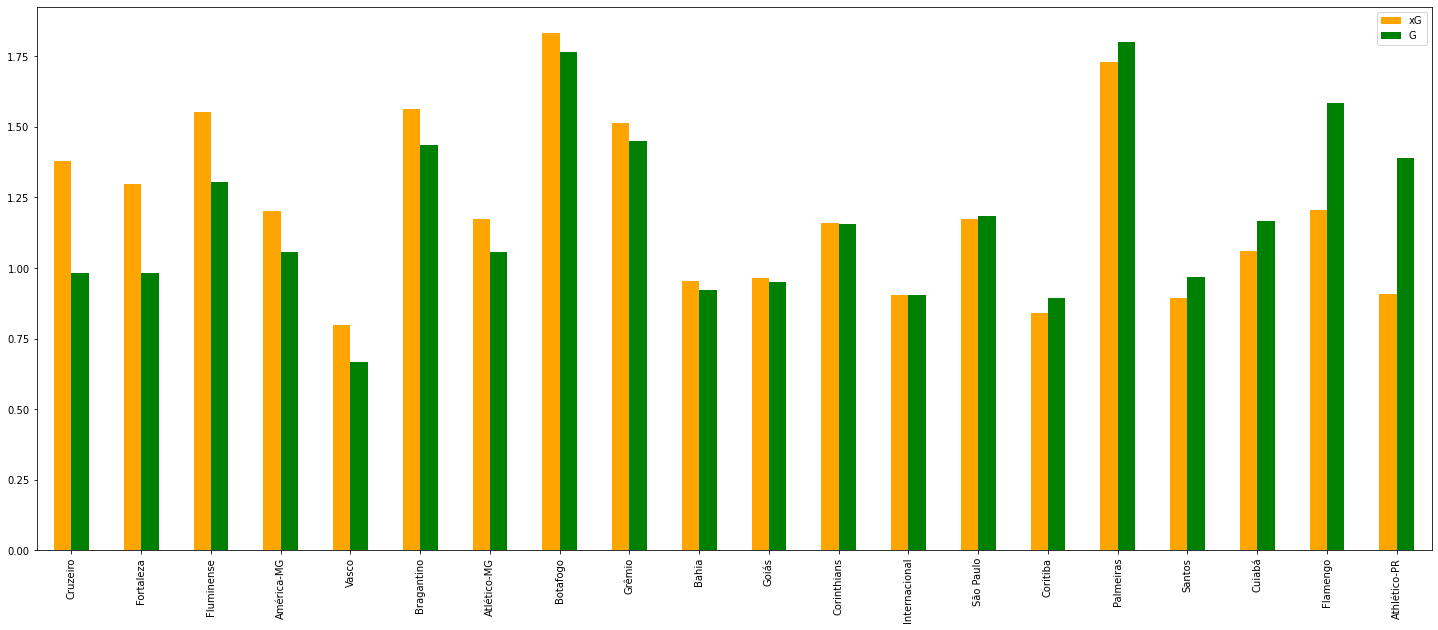

In [78]:
def plot_xg_vs_goals(df):
    df_composite = df.copy()
    df_composite['xG_G_comp'] = df_composite['xG_geral']-df_composite['Goal_geral']
    df_composite = df_composite.sort_values(by='xG_G_comp',ascending=False).reset_index(drop=True)

    xg = list(df_composite['xG_geral'].values)
    g = list(df_composite['Goal_geral'].values)
    index = list(df_composite['clube'].values)

    df = pd.DataFrame({'xG': xg,
                        'G': g}, index=index)
    matplotlib.use('Agg')
    ax = df.plot.bar(rot=90, color={"xG": "orange", "G": "green"},figsize=(25,10))
    ax.figure.savefig(f'img/xg_g_composite_r{rodada}.png')
    
    return df_composite

df_composite = plot_xg_vs_goals(df_xG_vs_Goals)

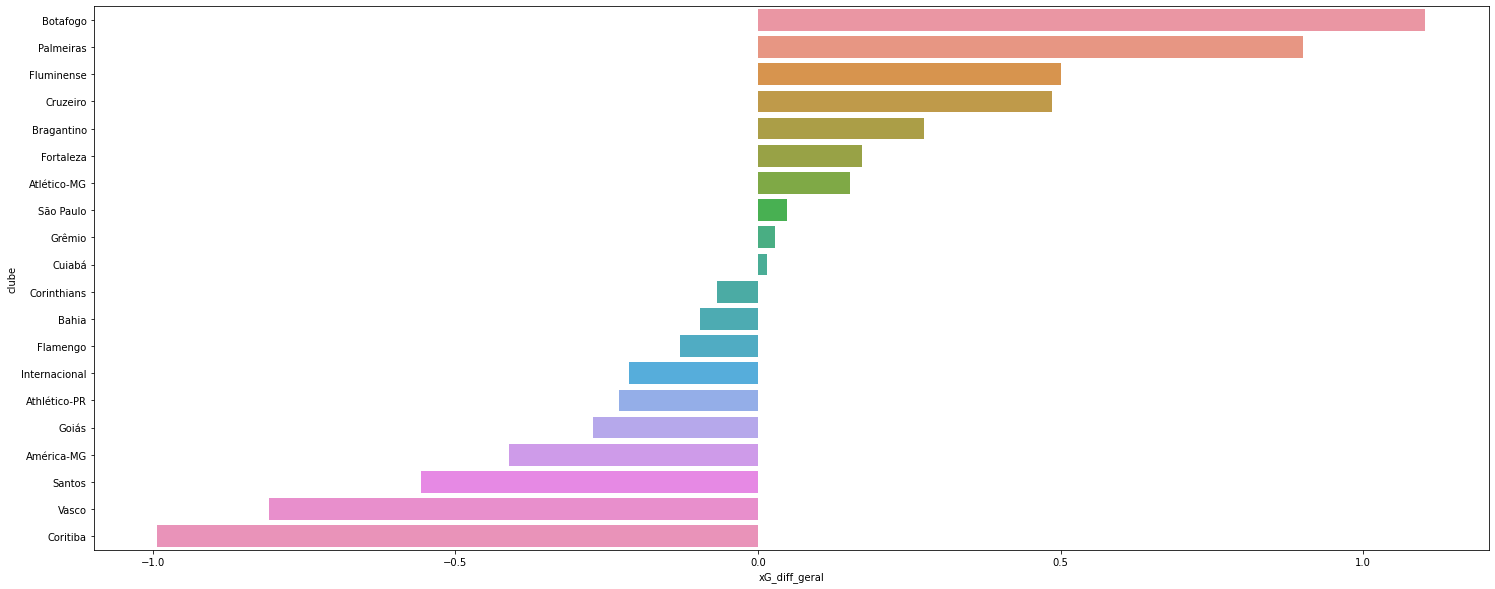

In [79]:
def plot_xG_vs_xGA(df):
    
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.barplot(x="xG_diff_geral", y="clube", data=df)
    ax.figure.savefig(f'img/xg_scored_minus_conceded_r{rodada}.png')
    
plot_xG_vs_xGA(df_xg_diff)

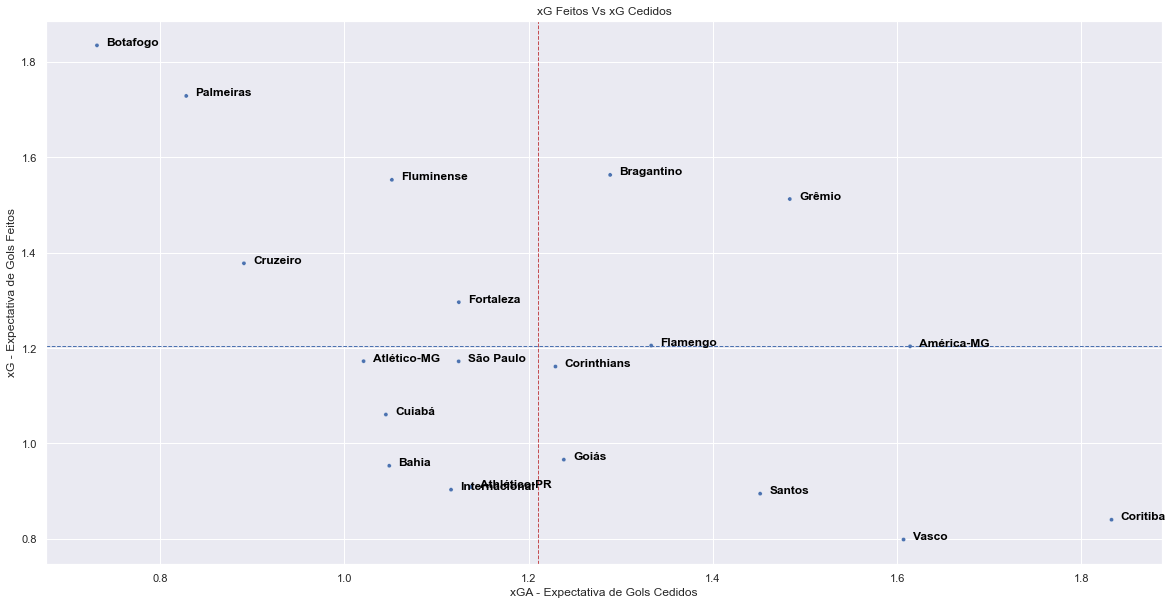

In [80]:
def xG_quadrantes(df_composite,rodada):
    df = df_composite.copy()
    # obter médias para o tracejado nos eixos
    xG_geral_mean = np.mean(list(df_composite['xG_geral'].values))
    xGA_geral_mean = np.mean(list(df_composite['xGA_geral'].values))
    
    sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xGA_geral', # Horizontal axis
       'xG_geral', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    ax.axhline(y=xG_geral_mean, color='b', linewidth=1, linestyle='--')  # added because i want the origin
    ax.axvline(x=xGA_geral_mean, color='r', linewidth=1, linestyle='--')
    
    for line in range(0,df.shape[0]):
         p1.text(df.xGA_geral[line]+0.01, df.xG_geral[line], 
         df.clube[line], horizontalalignment='left', 
         size='medium', color='black', weight='semibold')
    
    plt.title('xG Feitos Vs xG Cedidos')
    # Set x-axis label
    plt.xlabel('xGA - Expectativa de Gols Cedidos')
    # Set y-axis label
    plt.ylabel('xG - Expectativa de Gols Feitos')
    
    fig.savefig(f'img/xG_quadrantes{rodada}.png')


    
xG_quadrantes(df_composite,rodada)

In [81]:
jogos, confrontos, jogos_que_faltam = get_jogos_sde(2023,rodada)
jogos

{276: 263,
 285: 356,
 266: 327,
 1371: 275,
 283: 264,
 267: 282,
 277: 284,
 294: 262,
 265: 280,
 290: 293}

In [82]:
rodada

19

In [83]:
def xG_probs(df_xg_diff,edicao,rodada):
    jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao,rodada)
    # container for all simulations
    df_xG_probs = pd.DataFrame()
    for m,v in jogos.items():
        m = times_dict_r.get(m)
        v = times_dict_r.get(v)
        print (m,v)
        xG_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_casa'].iloc[0]
        xGA_casa = df_xg_diff[df_xg_diff['clube']==m]['xGA_casa'].iloc[0]
        xG_diff_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_diff_casa'].iloc[0]
        xG_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_fora'].iloc[0]
        xGA_fora = df_xg_diff[df_xg_diff['clube']==v]['xGA_fora'].iloc[0]
        xG_diff_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_diff_fora'].iloc[0]

        df_xG_probs = df_xG_probs.append({'next_rodada_id': rodada+1,
                                            'mandante':m, 
                                            'visitante':v, 
                                            'xG_mandante':(xG_casa+xGA_fora)/2,
                                            'xG_visitante':(xG_fora+xG_casa)/2},
                                            ignore_index=True)
        
        #df_xG_probs = prob_thresholds(df_xG_probs)
    return df_xG_probs

df_simul = xG_probs(df_xg_diff,2023,rodada)

São Paulo Botafogo
Internacional Fortaleza
Fluminense América-MG
Cuiabá Palmeiras
Cruzeiro Corinthians
Vasco Atlético-MG
Santos Grêmio
Coritiba Flamengo
Bahia Bragantino
Goiás Athlético-PR


In [84]:
df_simul

,next_rodada_id,mandante,visitante,xG_mandante,xG_visitante
0,20.0,São Paulo,Botafogo,1.300734,1.364761
1,20.0,Internacional,Fortaleza,1.163891,1.107988
2,20.0,Fluminense,América-MG,1.764145,1.394127
3,20.0,Cuiabá,Palmeiras,1.144262,1.229228
4,20.0,Cruzeiro,Corinthians,1.193524,0.881911
5,20.0,Vasco,Atlético-MG,0.747846,0.946089
6,20.0,Santos,Grêmio,1.343043,1.199434
7,20.0,Coritiba,Flamengo,1.187660,0.931065
8,20.0,Bahia,Bragantino,1.536811,1.389960
9,20.0,Goiás,Athlético-PR,1.279966,0.969179


In [85]:
#! pip install prettytable

In [86]:
df_xg_diff

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral
0,Botafogo,2.451613,0.374206,1.216897,1.088843,1.834255,0.731525,2.077407,0.128054,1.102730
1,Palmeiras,2.210103,0.580254,1.246443,1.076512,1.728273,0.828383,1.629849,0.169931,0.899890
2,Fluminense,1.576524,0.513596,1.528411,1.589664,1.552467,1.051630,1.062928,-0.061253,0.500838
3,Cruzeiro,1.161198,0.796207,1.593905,0.985888,1.377551,0.891047,0.364991,0.608017,0.486504
4,Bragantino,1.578234,0.736039,1.547347,1.841049,1.562791,1.288544,0.842196,-0.293702,0.274247
5,Fortaleza,1.436152,0.980835,1.155962,1.267770,1.296057,1.124302,0.455316,-0.111808,0.171754
6,Atlético-MG,1.099089,1.192564,1.245767,0.849280,1.172428,1.020922,-0.093476,0.396487,0.151506
7,São Paulo,1.512624,0.828706,0.831525,1.419581,1.172075,1.124144,0.683918,-0.588056,0.047931
8,Grêmio,1.796000,1.451505,1.228395,1.515613,1.512197,1.483559,0.344495,-0.287218,0.028638
9,Cuiabá,1.212013,0.945280,0.909159,1.144977,1.060586,1.045129,0.266732,-0.235818,0.015457


In [87]:
def simulate_round(df_xg_diff, edicao, rodada):
    times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

    times_dict_r = {v:k for k, v in times_dict.items()}

    jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao,rodada)
    print('Jogos da próxima rodada',jogos)
    # container for all simulations
    df_xG_probs = pd.DataFrame()
    for m,v in jogos.items():
        m = times_dict_r.get(m)
        v = times_dict_r.get(v)
        print (m,v)
        xG_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_casa'].iloc[0]
        xGA_casa = df_xg_diff[df_xg_diff['clube']==m]['xGA_casa'].iloc[0]
        xG_diff_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_diff_casa'].iloc[0]
        xG_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_fora'].iloc[0]
        xGA_fora = df_xg_diff[df_xg_diff['clube']==v]['xGA_fora'].iloc[0]
        xG_diff_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_diff_fora'].iloc[0]

        df_xG_probs = df_xG_probs.append({'rodada_id': rodada+1,
                                            'mandante':m, 
                                            'visitante':v, 
                                            'xG_mandante':(xG_casa+xGA_fora)/2,
                                            'xG_visitante':(xG_fora+xG_casa)/2},
                                            ignore_index=True)
    # Poisson with MonteCarlo Simulation
    all_homes = []
    all_aways=[]
    all_draws=[]
    all_homes_sg=[]
    all_aways_sg=[]
    all_draws_sg=[]
    all_home_xP = []
    all_away_xP = []
    num_simulations = 20000

    for i,row in df_xG_probs.iterrows():
        print("* Game #", i+1, "*")
        print("* Home team:", df_xG_probs.iloc[i]['mandante'])
        print("* Away team:", df_xG_probs.iloc[i]['visitante'])
        print("* Home team xG:", df_xG_probs.iloc[i]['xG_mandante'])
        print("* Away team xG:", df_xG_probs.iloc[i]['xG_visitante'])
        input_home_team = df_xG_probs.iloc[i]['mandante']
        input_home_team_xg = df_xG_probs.iloc[i]['xG_mandante']
        input_away_team = df_xG_probs.iloc[i]['visitante']
        input_away_team_xg = df_xG_probs.iloc[i]['xG_visitante']
        #print the simulation table and run simulations
        # print ("********************")
        # print ("*                  *")
        # print ("* SIMULATION TABLE *")
        # print ("*                  *")
        # print ("********************")
        count_home_wins = 0
        count_home_loss = 0
        count_away_wins = 0
        count_away_loss = 0
        count_draws = 0
        count_home_sg = 0
        count_away_sg = 0
        count_draw_sg = 0

        score_mat = []
        tot_sim_time = 0
        sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_home_team, input_away_team, "HOME WIN", "AWAY WIN", "DRAW", "SCORE MARGIN", "SG"])
        for i in range(num_simulations):
            #get simulation start time
            start_time = time.time()
            #run the sim - generate a random Poisson distribution
            target_home_goals_scored = np.random.poisson(input_home_team_xg)
            target_away_goals_scored = np.random.poisson(input_away_team_xg)
            home_win = 0
            away_win = 0
            draw = 0
            margin = 0
            sg = 0
            # if more goals for home team => home team wins
            if target_home_goals_scored > target_away_goals_scored:
                count_home_wins += 1
                count_away_loss += 1
                home_win = 1
                margin = target_home_goals_scored - target_away_goals_scored
                # check if sg
                if target_away_goals_scored == 0:
                    sg = 1
                    count_home_sg += 1
            # if more goals for away team => away team wins
            elif target_home_goals_scored < target_away_goals_scored:
                count_away_wins += 1
                count_home_loss += 1
                away_win = 1
                margin = target_away_goals_scored - target_home_goals_scored
                # check if sg
                if target_home_goals_scored == 0:
                    sg = 1
                    count_away_sg += 1
            elif target_home_goals_scored == target_away_goals_scored:
                draw = 1
                count_draws += 1
                margin = target_away_goals_scored - target_home_goals_scored
                # check if sg
                if target_home_goals_scored == 0 and target_away_goals_scored == 0:
                    sg = 1
                    count_draw_sg += 1
            # add score to score matrix
            score_mat.append((target_home_goals_scored, target_away_goals_scored))
            #get end time
            end_time = time.time()
            #add the time to the total simulation time
            tot_sim_time += round((end_time - start_time),5)
            #add the info to the simulation table
            sim_table.add_row([i+1, round((end_time - start_time),5), target_home_goals_scored, target_away_goals_scored, home_win, away_win, draw, margin, sg])
        #print(sim_table)

        # calculate probabilities to win/lose/draw
        home_win_probability = round((count_home_wins/num_simulations * 100),2)
        all_homes.append(home_win_probability)

        away_win_probability = round((count_away_wins/num_simulations * 100),2)
        all_aways.append(away_win_probability)

        draw_probability = round((count_draws/num_simulations * 100),2)
        all_draws.append(draw_probability)

        home_sg_probability = round((count_home_sg/num_simulations * 100),2)
        all_homes_sg.append(home_sg_probability)

        away_sg_probability = round((count_away_sg/num_simulations * 100),2)
        all_aways_sg.append(away_sg_probability)

        draw_sg_probability = round((count_draw_sg/num_simulations * 100),2)
        all_draws_sg.append(draw_sg_probability)
        
#         home_xP = round((home_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (away_win_probability / 100) * 0.0, 2)
#         all_home_xP.append(home_xP)
        
#         away_xP = round((away_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (home_win_probability / 100) * 0.0, 2)
#         all_away_xP.append(away_xP)

        # print the simulation statistics
        # print ("*************")
        # print ("*           *")
        # print ("* SIM STATS *")
        # print ("*           *")
        # print ("*************")
        sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "HOME WINS", "AWAY WINS", "DRAWS", "HOME SG", "AWAY SG", "DRAW SG"])
        sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_home_wins, count_away_wins, count_draws, count_home_sg, count_away_sg, count_draw_sg])
        sim_table_stats.add_row(["-", "-", str(home_win_probability)+"%", str(away_win_probability)+"%", str(draw_probability)+"%", str(home_sg_probability)+"%", str(away_sg_probability)+"%", str(draw_sg_probability)+"%"])
        print(sim_table_stats)


    df_xG_probs['percent_mandante'] = all_homes
    df_xG_probs['percent_visitante'] = all_aways
    df_xG_probs['percent_empate'] = all_draws

    df_xG_probs['percent_sg_mandante'] = all_homes_sg
    df_xG_probs['percent_sg_visitante'] = all_aways_sg
    df_xG_probs['percent_sg_empate'] = all_draws_sg
    
    # df_xG_probs['xP_mandante'] = all_home_xP
    # df_xG_probs['xP_visitante'] = all_away_xP

    return df_xG_probs

In [88]:
df_xG_probs = simulate_round(df_xg_diff, 2023, rodada)

Jogos da próxima rodada {276: 263, 285: 356, 266: 327, 1371: 275, 283: 264, 267: 282, 277: 284, 294: 262, 265: 280, 290: 293}
São Paulo Botafogo
Internacional Fortaleza
Fluminense América-MG
Cuiabá Palmeiras
Cruzeiro Corinthians
Vasco Atlético-MG
Santos Grêmio
Coritiba Flamengo
Bahia Bragantino
Goiás Athlético-PR
* Game # 1 *
* Home team: São Paulo
* Away team: Botafogo
* Home team xG: 1.3007338324199536
* Away team xG: 1.3647608905099333
+-----------------+-------------------------+-----------+-----------+--------+---------+---------+---------+
| Total # of sims | Total time (s) for sims | HOME WINS | AWAY WINS | DRAWS  | HOME SG | AWAY SG | DRAW SG |
+-----------------+-------------------------+-----------+-----------+--------+---------+---------+---------+
|      20000      |          0.001          |    7099   |    7686   |  5215  |   3777  |   4011  |   1369  |
|        -        |            -            |   35.49%  |   38.43%  | 26.07% |  18.88% |  20.05% |  6.84%  |
+-----------

In [89]:
df_xG_probs['sg_mandante_total'] = df_xG_probs['percent_sg_mandante'] + df_xG_probs['percent_sg_empate']
df_xG_probs['sg_visitante_total'] = df_xG_probs['percent_sg_visitante'] + df_xG_probs['percent_sg_empate']
df_xG_probs['sg_total'] = df_xG_probs['sg_mandante_total'] + df_xG_probs['sg_visitante_total']

In [90]:
df_xG_probs = df_xG_probs.assign(val=df_xG_probs[['sg_mandante_total', 'sg_visitante_total']].max(1)).sort_values('val', ascending=False)\
                                                                      .drop('val', 1)\
                                                                      .reset_index(drop=True).copy()

In [91]:
df_xG_probs

,rodada_id,mandante,visitante,xG_mandante,xG_visitante,percent_mandante,percent_visitante,percent_empate,percent_sg_mandante,percent_sg_visitante,percent_sg_empate,sg_mandante_total,sg_visitante_total,sg_total
0,20.0,Vasco,Atlético-MG,0.747846,0.946089,27.50,38.77,33.73,20.27,28.62,18.02,38.29,46.64,84.93
1,20.0,Cruzeiro,Corinthians,1.193524,0.881911,42.73,27.76,29.52,28.48,18.00,12.46,40.94,30.46,71.40
2,20.0,Coritiba,Flamengo,1.187660,0.931065,41.96,28.68,29.36,27.08,18.70,12.16,39.24,30.86,70.10
3,20.0,Goiás,Athlético-PR,1.279966,0.969179,42.79,28.21,29.00,27.27,17.16,10.85,38.12,28.01,66.13
4,20.0,Internacional,Fortaleza,1.163891,1.107988,36.71,35.22,28.07,22.30,21.26,10.00,32.30,31.26,63.56
5,20.0,Cuiabá,Palmeiras,1.144262,1.229228,33.34,38.76,27.90,19.48,22.85,9.41,28.89,32.26,61.15
6,20.0,Santos,Grêmio,1.343043,1.199434,40.52,33.17,26.31,22.81,18.14,7.68,30.49,25.82,56.31
7,20.0,São Paulo,Botafogo,1.300734,1.364761,35.49,38.43,26.07,18.88,20.05,6.84,25.72,26.89,52.61
8,20.0,Bahia,Bragantino,1.536811,1.389960,40.52,34.81,24.66,19.62,16.57,5.38,25.00,21.95,46.95
9,20.0,Fluminense,América-MG,1.764145,1.394127,46.13,30.86,23.01,20.36,12.88,4.04,24.40,16.92,41.32


In [92]:
df_xG_probs.to_csv(f'frames/sg_xg_R{rodada}_2023.csv')

In [93]:
# modelo_xG = pd.read_csv('clubes_xG_probs_R10.csv')
# modelo_gols = pd.read_csv('df_probabilidades_R10.csv')
# odds = pd.read_csv('df_odds_R10.csv')

# df_jogos = pd.DataFrame({'mandante':[m for m,v in jogos.items()],'visitante':[v for m,v in jogos.items()]})
# df_jogos['mandante'] = df_jogos['mandante'].map(times_dict_r)
# df_jogos['visitante'] = df_jogos['visitante'].map(times_dict_r)



# print(modelo_gols)
# print(modelo_xG)
# odds['odds_mandante_percent'] = (1/odds['odds_mandante'])*100
# odds['odds_visitante_percent'] = (1/odds['odds_visitante'])*100
# odds['odds_empate_percent'] = (1/odds['odds_empate'])*100

#odds_reduced = df_jogos.merge(odds, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])
# ##

# models = modelo_gols.merge(modelo_xG, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])


# all_models = models.merge(odds_reduced, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])

# all_models['prob_mandante_media'] = (all_models['percent_mandante']+all_models['prob_vitoria_mandante']+all_models['odds_mandante_percent'])/3
# all_models['prob_visitante_media'] = (all_models['percent_visitante']+all_models['prob_vitoria_visitante']+all_models['odds_visitante_percent'])/3
# all_models['prob_empate_media'] = (all_models['percent_empate']+all_models['prob_empate']+all_models['odds_empate_percent'])/3
# all_models['prob_sg_mandante_media'] = (all_models['percent_sg_mandante']+all_models['prob_sg_mandante'])/2
# all_models['prob_sg_visitante_media'] = (all_models['percent_sg_visitante']+all_models['prob_sg_visitante'])/2

# all_models = all_models[['rodada_id','mandante','visitante','prob_mandante_media','prob_empate_media','prob_visitante_media','prob_sg_mandante_media','prob_sg_visitante_media']]
# all_models


In [94]:
import seaborn as sns

def xG_philosophy_clubes(df_brasileiro, clube=None ,confrontos=None, rodada=None):
    

    df_clubes_xg = df_brasileiro.groupby(['clube_id','rodada_id'])['xG'].agg([('xG_sum','sum')]).reset_index()
    df_clubes_g = df_brasileiro.groupby(['clube_id','rodada_id'])['Goal'].agg([('Goal','sum')]).reset_index()
    # print(df_clubes_xg)
    # print(df_clubes_g)
    df_philo = df_clubes_xg.merge(df_clubes_g, how='left', left_on=['clube_id','rodada_id'], right_on=['clube_id','rodada_id'])
    # equipes como strings
    df_philo['clube'] = df_philo['clube_id'].map(times_dict_r) 
    
    # se desejamos apenas ver o histórico de xG de um clube ao longo do campeonato
    if clube:
        df_philo_clube = df_philo[df_philo['clube_id']==clube]
        # gerar dataframe
        df_philo_clube.to_csv(f'conteudo/xG_vs_Goals_{clube}_ate_R{rodada}_2023.csv', index=False)
        # abcissa
        x = list(df_philo_clube['rodada_id'].values)
        # figures
        fig=plt.figure(figsize=(20,10))
        fig.show()
        ax=fig.add_subplot(111)
        # gols e xG
        ax.plot(x,list(df_philo_clube['Goal'].values),c='b',marker="v",ls='-',label='Gols')
        ax.plot(x,list(df_philo_clube['xG_sum'].values),c='m',marker="o",ls='--',label='xG',fillstyle='none')
        # legenda
        plt.legend(loc=2)
        plt.draw()
        return df_philo_clube
    # se desejamos exibir os resultados dos jogos da rodada
    if confrontos:
        # pegar jogos
        jogos, confrontos, jogos_que_faltam = get_jogos_sde(2023,rodada-1)
        # para cada jogo
        for k,v in jogos.items():
            # obter métricas do confronto
            df_philo_confronto = df_philo[(df_philo['clube_id']==k) | (df_philo['clube_id']==v)].reset_index(drop=True)
            #print(df_philo_confronto[df_philo_confronto['rodada_id']==rodada])
            df_philo_confronto = df_philo_confronto[df_philo_confronto['rodada_id']==rodada]
            #print(df_philo_confronto)
            mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['clube'].iloc[0]
            visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['clube'].iloc[0]
            gols_mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['Goal'].iloc[0]
            gols_visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['Goal'].iloc[0]
            xg_mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['xG_sum'].iloc[0]
            xg_visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['xG_sum'].iloc[0]

            print(f'{mandante} ({xg_mandante.round(2)}) {gols_mandante} X {gols_visitante} ({xg_visitante.round(2)}) {visitante}')
            #print(gols_mandante, gols_visitante)
            #print(f'{xg_mandante.round(2)} {xg_visitante.round(2)}')

            print()
    return df_philo
    


#df_philo[df_philo['clube_id']==275]

In [95]:
xG_philosophy_clubes(df_brasileiro,confrontos=True,rodada=rodada)


Botafogo (2.48) 2 X 1 (0.38) Internacional

Atlético-MG (0.66) 1 X 0 (0.13) Bahia

Corinthians (2.35) 3 X 0 (0.86) Coritiba

Grêmio (2.16) 2 X 1 (0.94) Fluminense

América-MG (0.4) 0 X 1 (0.12) Goiás

Flamengo (1.2) 1 X 1 (0.13) São Paulo

Fortaleza (1.74) 3 X 0 (0.35) Santos

Palmeiras (2.12) 1 X 0 (0.26) Cruzeiro

Bragantino (2.21) 1 X 1 (0.93) Vasco



IndexError: single positional indexer is out-of-bounds

,clube_id,rodada_id,xG_sum,Goal,clube
2,262,1,0.615141,3,Flamengo
3,262,2,2.038622,1,Flamengo
4,262,3,2.297251,2,Flamengo
5,262,4,1.306197,1,Flamengo
6,262,5,1.759080,2,Flamengo
7,262,6,2.139524,3,Flamengo
8,262,7,0.037773,0,Flamengo
9,262,8,1.265176,1,Flamengo
10,262,9,2.913495,4,Flamengo
11,262,10,1.248954,3,Flamengo


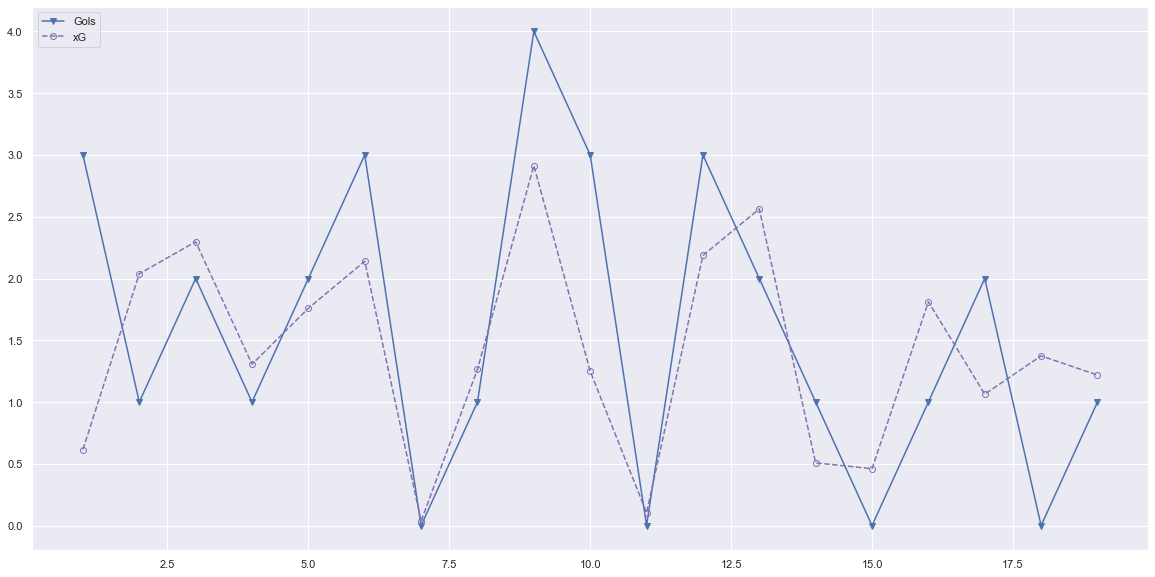

In [ ]:
xG_philosophy_clubes(df_brasileiro,clube=262,rodada=rodada)

# xG Atletas

#### Agora vamos fazer o cálculo de xG etc sob a perspectiva dos atletas

- Estudo 01. xG total
- Estudo 02. xG por jogo
- Estudo 03. xG vs gols
- Estudo 04. xG como medida de eficiência
- Estudo 05. xG como medida de potencial

## xG Total

In [96]:
df_atletas = df_brasileiro.groupby(['atleta_id', 'apelido','clube_id'])['xG'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xG',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xG']]
df_atletas.head(30)

,apelido,clube_id,clube,xG
0,Tiquinho Soares,263,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,10.704835
1,Hulk,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,5.963113
2,Deyverson,1371,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,5.941963
3,Cano,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,5.868357
4,Marcos Leonardo,277,![Santos](https://s.glbimg.com/es/sde/f/organi...,5.851653
5,Gilberto,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,5.808881
6,Yuri Alberto,264,![Corinthians](https://s.glbimg.com/es/sde/f/o...,5.682090
7,Calleri,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,5.458932
8,Lelê,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,5.380133
9,Luis Suárez,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,5.222443


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [ ]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xG_total=('xG', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xG_per_match']=df_atletas2['xG_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xG_per_shot'] = df_atletas2['xG_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xG_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,12.526746,46,14,13,0.894768,0.928571,0.272321,3.538462,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,109497,Marcos Leonardo,277,7.230233,31,13,7,0.556172,0.538462,0.233233,4.428571,![Santos](https://s.glbimg.com/es/sde/f/organi...
2,92708,Deyverson,1371,7.048478,34,14,8,0.503463,0.571429,0.207308,4.250000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...
3,114802,Vitor Roque,293,6.870238,38,13,8,0.528480,0.615385,0.180796,4.750000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
4,79631,Cano,266,5.508308,41,15,6,0.367221,0.400000,0.134349,6.833333,![Fluminense](https://s.glbimg.com/es/sde/f/or...
5,106199,Gabriel Pec,267,5.195757,37,15,3,0.346384,0.200000,0.140426,12.333333,![Vasco](https://s.glbimg.com/es/sde/f/organiz...
6,69318,Luis Suárez,284,5.134843,60,15,4,0.342323,0.266667,0.085581,15.000000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
7,89898,Róger Guedes,264,4.917861,43,13,6,0.378297,0.461538,0.114369,7.166667,![Corinthians](https://s.glbimg.com/es/sde/f/o...
8,39148,Hulk,282,4.801700,66,17,7,0.282453,0.411765,0.072753,9.428571,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
9,94583,Pedro,262,4.542776,23,13,5,0.349444,0.384615,0.197512,4.600000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...


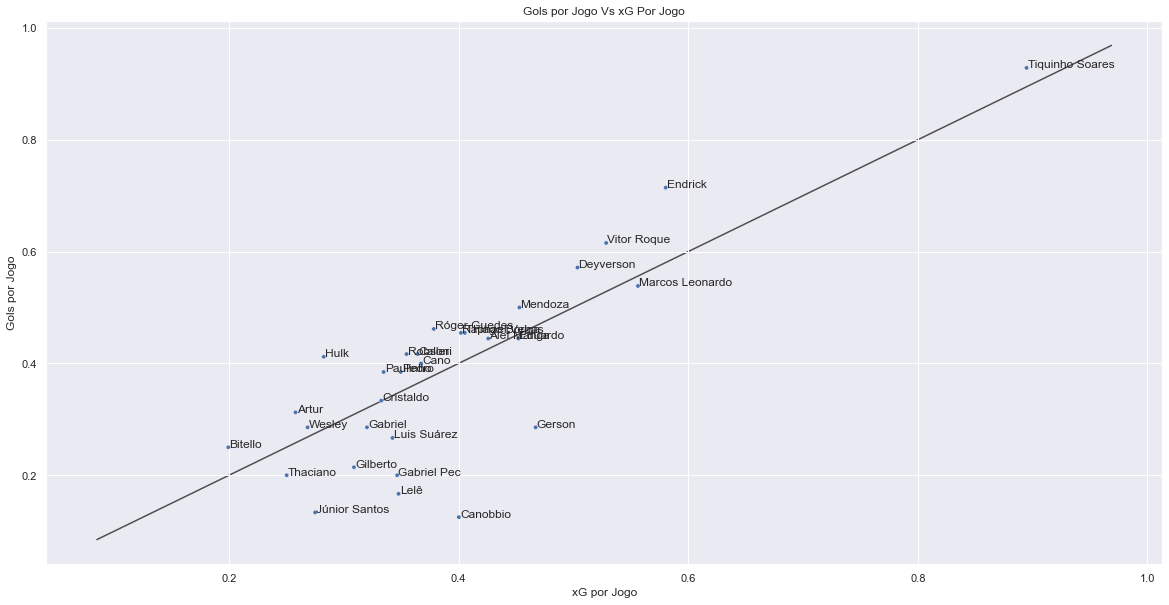

In [ ]:
def xG_fit(df,rodada):
    # pegar apenas 30
    df = df.head(30)
    # # obter médias para o tracejado nos eixos
    # xG_geral_mean = np.mean(list(df['xG_geral'].values))
    # xGA_geral_mean = np.mean(list(df['xGA_geral'].values))
    
    #sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xG_per_match', # Horizontal axis
       'G_per_match', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    
    plt.title('Gols por Jogo Vs xG Por Jogo')
    # Set x-axis label
    plt.xlabel('xG por Jogo')
    # Set y-axis label
    plt.ylabel('Gols por Jogo')
    
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.001, point['y'], str(point['val']))
            #ax.plot([-1,1],[-1,1], 'red', linewidth=10)

            
    label_point(df.xG_per_match, df.G_per_match, df.apelido, plt.gca())  

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    
    fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')
    
xG_fit(xg_total,rodada)

## xG per match

In [318]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

7.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,12.526746,46,14,13,0.894768,0.928571,0.272321,3.538462,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,115959,Endrick,275,4.062495,13,7,5,0.580356,0.714286,0.312500,2.600000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
2,109497,Marcos Leonardo,277,7.230233,31,13,7,0.556172,0.538462,0.233233,4.428571,![Santos](https://s.glbimg.com/es/sde/f/organi...
3,114802,Vitor Roque,293,6.870238,38,13,8,0.528480,0.615385,0.180796,4.750000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
4,92708,Deyverson,1371,7.048478,34,14,8,0.503463,0.571429,0.207308,4.250000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...
5,89256,Gerson,262,3.269062,13,7,2,0.467009,0.285714,0.251466,6.500000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
6,90031,Mendoza,277,4.528296,27,10,5,0.452830,0.500000,0.167715,5.400000,![Santos](https://s.glbimg.com/es/sde/f/organi...
7,68708,Eduardo,263,4.067351,15,9,4,0.451928,0.444444,0.271157,3.750000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
8,101254,Alef Manga,294,3.831593,27,9,4,0.425733,0.444444,0.141911,6.750000,![Coritiba](https://s.glbimg.com/es/sde/f/orga...
9,117314,Thiago Borbas,280,4.458341,24,11,5,0.405304,0.454545,0.185764,4.800000,![Bragantino](https://s.glbimg.com/es/sde/f/or...


In [319]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)



## xG vs Gols

Um estudo comparativo entre Gols e Expected Gols pode ser visto sob dois prismas:

- Eficiência
- Potencial

### 'Eficiência' mede, a partir da diferença entre uma métrica e outra, o nível de aproveitamento dos atletas.

In [320]:
df_atletas2['eficiência'] = df_atletas2['goals_total']-df_atletas2['xG_total']
df_eficiencia = df_atletas2.loc[df_atletas2['goals_total']>=1].sort_values(by='eficiência',ascending=False).reset_index(drop=True).head(50)
df_eficiencia.dropna()

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,70360,Eduardo Sasha,280,1.421711,25,14,5,0.101551,0.357143,0.056868,5.000000,![Bragantino](https://s.glbimg.com/es/sde/f/or...,3.578289
1,39148,Hulk,282,4.801700,66,17,7,0.282453,0.411765,0.072753,9.428571,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.198300
2,91607,Rony,275,2.086108,20,10,4,0.208611,0.400000,0.104305,5.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.913892
3,87863,Arrascaeta,262,1.163226,23,10,3,0.116323,0.300000,0.050575,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.836774
4,106002,Johnny,285,0.248407,9,7,2,0.035487,0.285714,0.027601,4.500000,![Internacional](https://s.glbimg.com/es/sde/f...,1.751593
5,89918,Everton Galdino,284,0.252649,8,7,2,0.036093,0.285714,0.031581,4.000000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.747351
6,91473,Erick Pulgar,262,0.253468,5,4,2,0.063367,0.500000,0.050694,2.500000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.746532
7,106202,Bruno Gomes,294,0.281831,23,11,2,0.025621,0.181818,0.012254,11.500000,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,1.718169
8,80287,Luciano,276,2.283035,35,12,4,0.190253,0.333333,0.065230,8.750000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.716965
9,106704,Carlos Alberto,263,0.366813,3,3,2,0.122271,0.666667,0.122271,1.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.633187


In [321]:
df_eficiencia = df_eficiencia[['apelido','clube','xG_total','goals_total','xG_per_match','G_per_match','shots_per_goal']]
df_eficiencia.head(20).to_csv(f'conteudo/Eficiencia_ate_R{rodada}.csv', index=False)
df_eficiencia

,apelido,clube,xG_total,goals_total,xG_per_match,G_per_match,shots_per_goal
0,Eduardo Sasha,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.421711,5,0.101551,0.357143,5.000000
1,Hulk,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,4.801700,7,0.282453,0.411765,9.428571
2,Rony,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,2.086108,4,0.208611,0.400000,5.000000
3,Arrascaeta,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.163226,3,0.116323,0.300000,7.666667
4,Johnny,![Internacional](https://s.glbimg.com/es/sde/f...,0.248407,2,0.035487,0.285714,4.500000
5,Everton Galdino,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,0.252649,2,0.036093,0.285714,4.000000
6,Erick Pulgar,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.253468,2,0.063367,0.500000,2.500000
7,Bruno Gomes,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,0.281831,2,0.025621,0.181818,11.500000
8,Luciano,![São Paulo](https://s.glbimg.com/es/sde/f/org...,2.283035,4,0.190253,0.333333,8.750000
9,Carlos Alberto,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,0.366813,2,0.122271,0.666667,1.500000


### 'Potencial' mede, por outro lado, aqueles atletas que tem maior potencial de crescimento
Se invertermos o ranking, vemos quem está no topo do aproveitamente abaixo do esperado, ou seja, com maiores possibilidades de convergência para a expectativa

In [322]:
# note: ascending = True
df_potencial = df_atletas2.loc[df_atletas2['goals_total']>=1].head(20).sort_values(by='eficiência',ascending=True).reset_index(drop=True)
df_potencial

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,61188,Gilberto,283,4.322539,34,14,3,0.308753,0.214286,0.127133,11.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...,-1.322539
1,38279,Wellington Paulista,327,1.575501,9,4,1,0.393875,0.250000,0.175056,9.000000,![América-MG](https://s.glbimg.com/es/sde/f/o...,-0.575501
2,69102,Vargas,282,1.250635,5,3,1,0.416878,0.333333,0.250127,5.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,-0.250635
3,50347,Alan Kardec,282,1.109506,5,3,1,0.369835,0.333333,0.221901,5.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,-0.109506
4,68708,Eduardo,263,4.067351,15,9,4,0.451928,0.444444,0.271157,3.750000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,-0.067351
5,42116,Willian,293,2.027280,4,4,2,0.506820,0.500000,0.506820,2.000000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,-0.027280
6,69138,Pablo,293,2.958359,20,9,3,0.328707,0.333333,0.147918,6.666667,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,0.041641
7,52827,David Luiz,262,0.905579,5,4,1,0.226395,0.250000,0.181116,5.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.094421
8,38398,Renato Augusto,264,0.835228,7,5,1,0.167046,0.200000,0.119318,7.000000,![Corinthians](https://s.glbimg.com/es/sde/f/o...,0.164772
9,51772,Everton Ribeiro,262,1.676569,14,10,2,0.167657,0.200000,0.119755,7.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.323431


In [105]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3886 entries, 101919 to 275553
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Codigo         3886 non-null   int64  
 1   Lance          3886 non-null   object 
 2   Nome           3886 non-null   object 
 3   Ocorrencia     3886 non-null   object 
 4   PosicaoLance   3886 non-null   int64  
 5   TempoPartida   3886 non-null   int64  
 6   TimestampStr   3886 non-null   object 
 7   atleta_id      3886 non-null   int64  
 8   apelido        3886 non-null   object 
 9   sigla          3886 non-null   object 
 10  posicao_id     3886 non-null   int64  
 11  match_id       3886 non-null   float64
 12  tempo          3886 non-null   object 
 13  tempo_2        3886 non-null   object 
 14  clube_id       3886 non-null   int64  
 15  Codigo_SCT     3886 non-null   float64
 16  match_id_sct   3886 non-null   float64
 17  rodada_id      3886 non-null   int64  
 18  T

In [104]:
# def xG_geral(df, row):
#     # Geral
#     conquistado_geral = df[(df['rodada_id']<=row['rodada_id']) & \
#                            (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_geral[0]

# def xG_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     conquistado_mandante_posicao = df[(df['home_dummy']==1) & \
#                                       (df['clube_id']==row['clube_id']) & \
#                                       (df['rodada_id']<=row['rodada_id']) & \
#                                       (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_mandante_geral = df[(df['home_dummy']==1) & \
#                                     (df['rodada_id']<=row['rodada_id']) & \
#                                     (df['clube_id']==row['clube_id'])][['xG']].mean()
#     # Visitante
#     # Posicao
#     conquistado_visitante_posicao = df[(df['home_dummy']==0) & \
#                                        (df['clube_id']==row['clube_id']) & \
#                                        (df['rodada_id']<=row['rodada_id']) & \
#                                        (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_visitante_geral = df[(df['home_dummy']==0) & \
#                                      (df['rodada_id']<=row['rodada_id']) & \
#                                      (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_mandante_posicao[0], conquistado_mandante_geral[0], conquistado_visitante_posicao[0], conquistado_visitante_geral[0]

# # xG allowed
# def xGA_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     cedido_mandante_posicao = df[(df['home_dummy']==0) & \
#                                  (df['adversario_id']==row['equipe_id']) & \
#                                  (df['rodada_id']<=row['rodada_id']) & \
#                                  (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_mandante_geral = df[(df['home_dummy']==0) & \
#                                (df['rodada_id']<=row['rodada_id']) & \
#                                (df['adversario_id']==row['equipe_id'])][['xG']].mean()

#     # Visitante
#     # Posicao
#     cedido_visitante_posicao = df[(df['home_dummy']==1) & \
#                                   (df['adversario_id']==row['equipe_id']) & \
#                                   (df['rodada_id']<=row['rodada_id']) & \
#                                   (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_visitante_geral = df[(df['home_dummy']==1) & \
#                                 (df['rodada_id']<=row['rodada_id']) & \
#                                 (df['adversario_id']==row['equipe_id'])][['xG']].mean()


#     return cedido_mandante_posicao[0], cedido_mandante_geral[0], cedido_visitante_posicao[0], cedido_visitante_geral[0]

# df_brasileiro['xg_mando_pos'] = df_brasileiro.apply(lambda x: xG_mando_posicao(df_brasileiro, x))
# #print (df_brasileiro.query('rodada_id >= 1')[('sum', 'xG')].mean())